# Natural Language Processing
## Assignment - 2
### Group Members
1. Donal Loitam (AI21BTECH11009)
2. Sai Pradeep (AI21BTECH11013)
3. Suraj Kumar (AI21BTECH11029)

In [77]:
!pip install pandas numpy matplotlib seaborn nltk scikit-learn torch


In [78]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


In [79]:
# Download stopwords if not already available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ai21btech11012/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# DATASET 1

## Data Understanding

In [80]:
!pip install openpyxl

In [81]:
file_path = 'sample_data/Dataset-1.xlsx'
df = pd.read_excel(file_path)
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [82]:
print(df.columns)

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


In [83]:
# Check for missing values,  class imbalance, and other issues.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB
None


## Data Preprocessing
1. Define a function for processing text
2. Create labels and convert labels into a binary multi-label format
3. Split data into train-test sets

In [84]:
def process_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    new_processed_text = ' '.join(words)
    return new_processed_text

In [85]:
# Apply this function to title and abstract columns of the df
df['processed_title'] = df['TITLE'].apply(process_text)
df['processed_abstract'] = df['ABSTRACT'].apply(process_text)

# Merge these columns into one
df['processed_text'] = df['processed_title'] + ' ' + df['processed_abstract']
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,processed_title,processed_abstract,processed_text
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,reconstructing subjectspecific effect maps,predictive models allow subjectspecific infere...,reconstructing subjectspecific effect maps pre...
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,rotation invariance neural network,rotation invariance translation invariance gre...,rotation invariance neural network rotation in...
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,spherical polyharmonics poisson kernels polyha...,introduce develop notion spherical polyharmoni...,spherical polyharmonics poisson kernels polyha...
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,finite element approximation stochastic maxwel...,stochastic landaulifshitzgilbert llg equation ...,finite element approximation stochastic maxwel...
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,comparative study discrete wavelet transforms ...,fouriertransform infrared ftir spectra samples...,comparative study discrete wavelet transforms ...


In [86]:
# Columns 3 to 8 are labels, so extract these column names and store it in a list
label_columns = df.columns[3:9]
print(label_columns)

# Prepare Labels (Multi-label classification)
df["labels"] = df[label_columns].apply(lambda x: list(np.where(x == 1)[0]), axis=1)

# Convert multi-labels into binary format
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["labels"])

Index(['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


In [87]:
# Check for class imbalance
label_counts = df[label_columns].sum()
print(label_counts)

Computer Science        8594
Physics                 6013
Mathematics             5618
Statistics              5206
Quantitative Biology     587
Quantitative Finance     249
dtype: int64


In [88]:
df

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,processed_title,processed_abstract,processed_text,labels
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,reconstructing subjectspecific effect maps,predictive models allow subjectspecific infere...,reconstructing subjectspecific effect maps pre...,[0]
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,rotation invariance neural network,rotation invariance translation invariance gre...,rotation invariance neural network rotation in...,[0]
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,spherical polyharmonics poisson kernels polyha...,introduce develop notion spherical polyharmoni...,spherical polyharmonics poisson kernels polyha...,[2]
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,finite element approximation stochastic maxwel...,stochastic landaulifshitzgilbert llg equation ...,finite element approximation stochastic maxwel...,[2]
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,comparative study discrete wavelet transforms ...,fouriertransform infrared ftir spectra samples...,comparative study discrete wavelet transforms ...,"[0, 3]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0,contemporary machine learning guide practition...,machine learning finding increasingly broad ap...,contemporary machine learning guide practition...,"[0, 1]"
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0,uniform diamond coatings wcco hard alloy cutti...,polycrystalline diamond coatings grown cemente...,uniform diamond coatings wcco hard alloy cutti...,[1]
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0,analysing soccer games clustering conceptors,present new approach identifying situations be...,analysing soccer games clustering conceptors p...,[0]
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0,efficient simulation lefttail sum correlated l...,sum lognormal variates encountered many challe...,efficient simulation lefttail sum correlated l...,"[2, 3]"


In [89]:
# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(df["processed_text"], y, test_size=0.2, random_state=42)

# Print the train and test set shape
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Display a sample processed data
print(f"Sample Text: {X_train.iloc[0]}")
print(f"Labels: {y_train[0]}")

Train set shape: (16777,)
Test set shape: (4195,)
Sample Text: reverse quantum annealing approach portfolio optimization problems investigate hybrid quantumclassical solution method meanvariance portfolio optimization problems starting real financial data statistics following principles modern portfolio theory generate parametrized samples portfolio optimization problems related quadratic binary optimization forms programmable analog dwave quantum annealer 2000q instances also solvable industryestablished genetic algorithm approach use classical benchmark investigate several options run quantum computation optimally ultimately discovering best results terms expected timetosolution function number variables hardest instances set obtained seeding quantum annealer solution candidate found greedy local search performing reverse annealing protocol optimized reverse annealing protocol found 100 times faster corresponding forward quantum annealing average
Labels: [0 0 0 0 0 1]


## Feature extraction/Representation
Convert text data (titles and abstracts) into numerical representations
1. Bag of Words (BoW)
2. TF-IDF (Term Frequency-Inverse Document Frequency)
3. Word Embeddings (Word2Vec, GloVe)

- We will be using **TF-IDF** since it is known to work well with text classification using *Classical ML models*.
- Among word embeddings, we would experiment with **Word2Vec** and **GloVe** for *Deep Learning models*.

In [90]:
!pip install gensim
!pip install scikit-learn

In [91]:
# 1. Use BoW representation
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=5000)  # Keep only top 5000 words

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print("BoW representation shape:", X_train_bow.shape)

BoW representation shape: (16777, 5000)


In [92]:
# 2. Use tf-idf vectoriser
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)    # Use 5000 features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF representation shape:", X_train_tfidf.shape)

TF-IDF representation shape: (16777, 5000)


In [93]:
# 3. Use Word2Vec and train it from scratch
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# Tokenize the text data
tokenized_train_texts = [text.split() for text in X_train]
word2vec_model = Word2Vec(
    sentences=tokenized_train_texts,
    vector_size=100,            # what dimensions should the vector be of
    window=5,                   # Context window size
    min_count=2,
    sg=1                         # Use skip-gram (sg=1)
)


# Function to get average word2Vec
def get_average_word2vec(text, model, vec_size=100):
    words = text.split()
    vectorized_words = [model.wv[word] for word in words if word in model.wv]
    if not vectorized_words:
        return np.zeros(vec_size)
    avg_vector = np.mean(vectorized_words, axis=0)
    return avg_vector


X_train_w2v = np.array([get_average_word2vec(text, word2vec_model, 100) for text in X_train])
X_test_w2v = np.array([get_average_word2vec(text, word2vec_model, 100) for text in X_test])

print("Word2Vec representation shape:", X_train_w2v.shape)

Word2Vec representation shape: (16777, 100)


In [95]:
# FastText 
# 4. Use FastText and train it from scratch
from gensim.models import FastText
from gensim.utils import simple_preprocess

# Tokenize the text data
tokenized_train_texts = [text.split() for text in X_train]
fasttext_model = FastText(
    sentences=tokenized_train_texts,
    vector_size=100,            # what dimensions should the vector be of
    window=5,                   # Context window size
    min_count=2,
    sg=1                         # Use skip-gram (sg=1)
)


# Function to get average word2Vec
def get_average_FastText(text, model, vec_size=100):
    words = text.split()
    vectorized_words = [model.wv[word] for word in words if word in model.wv]
    if not vectorized_words:
        return np.zeros(vec_size)
    avg_vector = np.mean(vectorized_words, axis=0)
    return avg_vector


X_train_ft = np.array([get_average_FastText(text, fasttext_model, 100) for text in X_train])
X_test_ft = np.array([get_average_FastText(text, fasttext_model, 100) for text in X_test])

print("FastText representation shape:", X_train_ft.shape)

FastText representation shape: (16777, 100)


# MODELS

In [ ]:
!pip install scikit-multilearn
!pip install --upgrade scikit-learn
!pip install --upgrade scikit-multilearn
!pip install scikit-learn

# Classical



In [96]:
import sklearn.metrics
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix

def TestMultiLabel(y_true, y_pred, embedding_model,model_name):
    print("--------------")
    print(f"Results of {model_name} with {embedding_model} embeddings")
    
    exact_match = sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f'Exact Match Ratio: {exact_match:.4f}')
    
    hamming_loss = sklearn.metrics.hamming_loss(y_true, y_pred)
    print(f'Hamming Loss: {hamming_loss:.4f}')
    
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='samples')
    print(f'Recall: {recall:.4f}')
    
    precision = sklearn.metrics.precision_score(y_true, y_pred, average='samples')
    print(f'Precision: {precision:.4f}')
    
    f1_measure = sklearn.metrics.f1_score(y_true, y_pred, average='samples')
    print(f'F1 Score: {f1_measure:.4f}')
    
    cm = multilabel_confusion_matrix(y_true, y_pred)
    num_labels = cm.shape[0]

    # Create a plot with the confusion matrices for each label
    fig, axes = plt.subplots(1, num_labels, figsize=(25, 10))
    for i, ax in enumerate(axes):
        im = ax.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
        
        # Add text annotations to the confusion matrix
        for j in range(2):
            for k in range(2):
                ax.text(k, j, f'{cm[i][j, k]}', ha='center', va='center', color='black')
        
        ax.set_title(f'Label {i}')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    print("--------------")
    
class BinaryRelenvanceSVC():
  def __init__(self,X_train,y_train):

    self.model = OneVsRestClassifier(SVC(kernel='linear'))
    self.X_train = X_train
    self.y_train = y_train

  def fit(self):
    self.model.fit(self.X_train, self.y_train)

  def predict(self, X_test):
    self.y_output=self.model.predict(X_test)
    return self.y_output

  def test(self, y_test,embedding_model="BoW",model_name="SVC"):
    TestMultiLabel(y_test, self.y_output,embedding_model,model_name)

### (i) BoW Embeddings

In [99]:
# BOW + BinaryRelanvenceSVC
bow_SVC=BinaryRelenvanceSVC(X_train_bow, y_train)
bow_SVC.fit()
y_bow_cc=bow_SVC.predict(X_test_bow)

--------------
Results of SVC with BoW embeddings
Exact Match Ratio: 0.5247
Hamming Loss: 0.1122
Recall: 0.7743
Precision: 0.7316
F1 Score: 0.7283


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


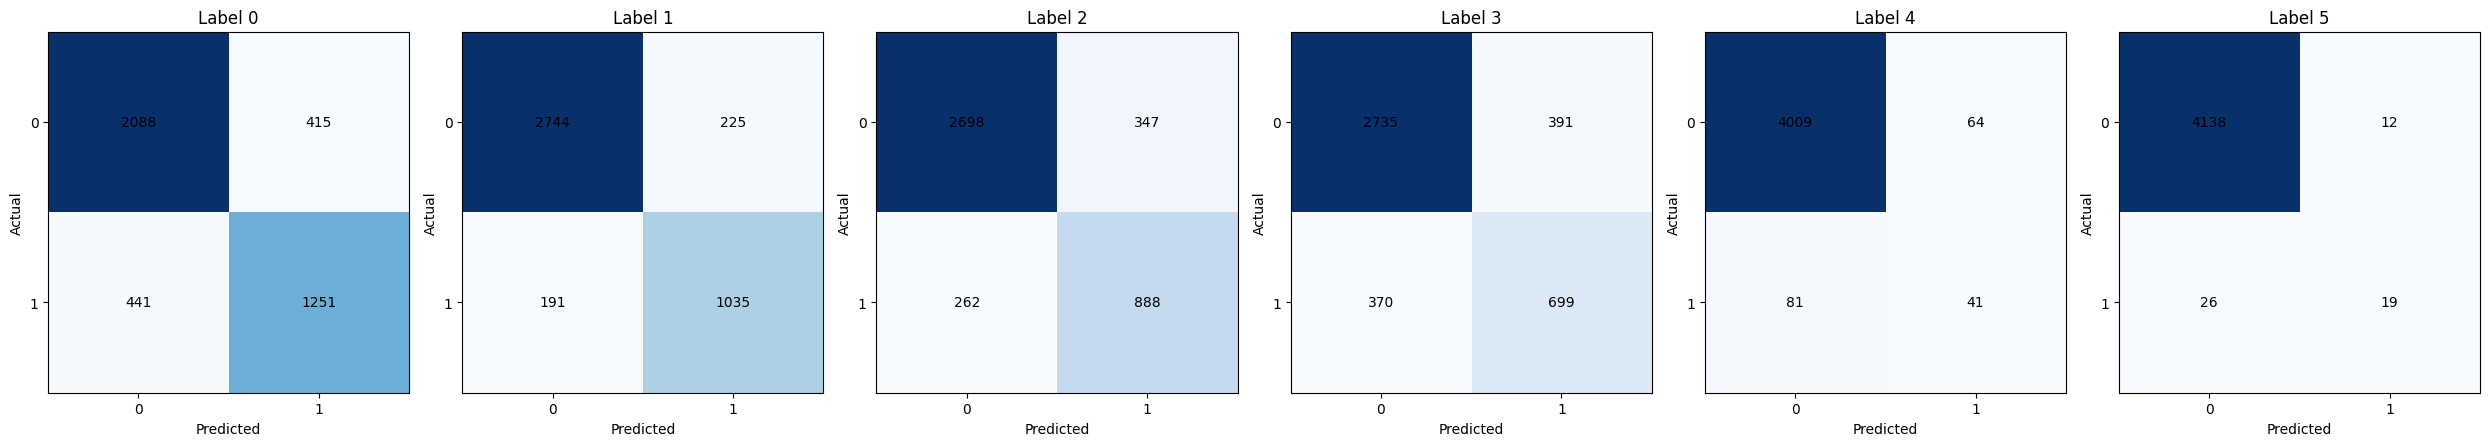

--------------


In [100]:
TestMultiLabel(y_test, y_bow_cc,embedding_model="BoW", model_name="SVC")

### (ii) TF-IDF Embeddings

--------------
Results of SVM with TF-IDF embeddings
Exact Match Ratio: 0.6491
Hamming Loss: 0.0779
Recall: 0.8095
Precision: 0.8241
F1 Score: 0.7990


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


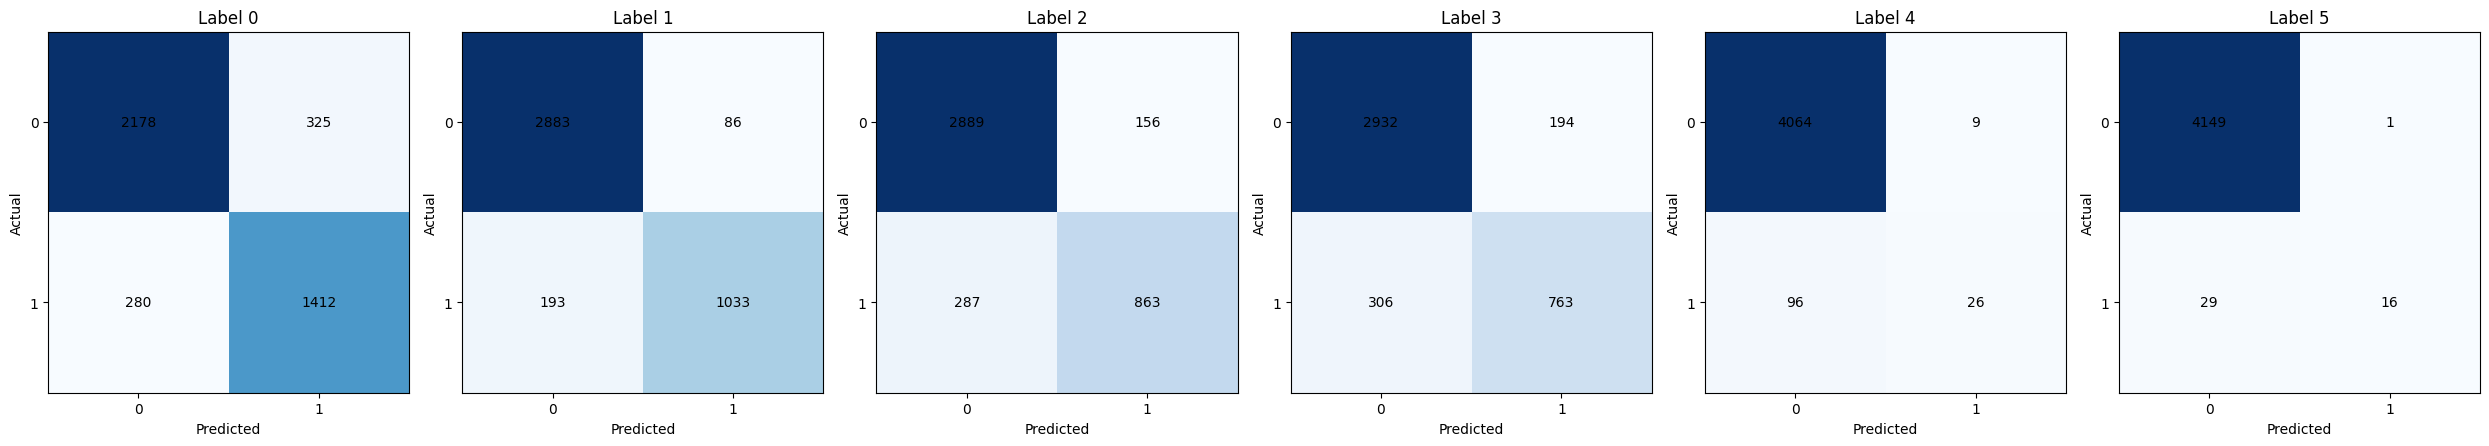

--------------


In [101]:

tfidf_svm=BinaryRelenvanceSVC(X_train_tfidf, y_train)
tfidf_svm.fit()
y_tfidf_cc=tfidf_svm.predict(X_test_tfidf)
tfidf_svm.test(y_test, embedding_model="TF-IDF", model_name="SVM")

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Deep Learning


In [111]:
import numpy as np

def Results(model, dataloader, criterion,model_name="BiLSTM",embedding_model='Word2Vec',type="test", device="none"):
    model.eval()
    total_loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            binary_preds = (outputs > 0.5).cpu().numpy()
            true_labels = targets.cpu().numpy()

            y_pred.append(binary_preds)
            y_true.append(true_labels)

    print(f'{model_name} with {embedding_model} embeddings {type} loss is {total_loss / len(dataloader)}')
    y_pred = np.vstack(y_pred)
    y_true = np.vstack(y_true)
    return y_pred, y_true

In [104]:
# split data into train, val, test as 50 20 30

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["labels"])

X_train1, X_test_val1, y_train1, y_test_val1 = train_test_split(df["processed_text"], y, test_size=0.5, random_state=42)

X_test1, X_val1, y_test1, y_val1 = train_test_split(X_test_val1, y_test_val1, test_size=0.4, random_state=42)


# Model 2 : ANN

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x



In [105]:

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
# Tokenize text into words
train_tokens = X_train.apply(word_tokenize).tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)



def get_average_word2vec(text, model, vec_size=100):
    words = text.split()
    vectorized_words = [model.wv[word] for word in words if word in model.wv]
    if not vectorized_words:
        return np.zeros(vec_size)
    avg_vector = np.mean(vectorized_words, axis=0)
    return avg_vector

X_train1_word2vec = np.array([get_average_word2vec(text, word2vec_model, 100) for text in X_train1])
X_val1_word2vec = np.array([get_average_word2vec(text, word2vec_model, 100) for text in X_val1])
X_test1_word2vec = np.array([get_average_word2vec(text, word2vec_model, 100) for text in X_test1])

print("Word2Vec representation shape:", X_train1_word2vec.shape)


Word2Vec representation shape: (10486, 100)


In [ ]:

model_ann = ANNModel(100, 128, 6).to(device)
X_train_tensor = torch.tensor(X_train1_word2vec, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train1, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val1_word2vec, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val1, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test1_word2vec, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test1, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_ann.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model_ann.train()
    total_loss = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        output = model_ann(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    model_ann.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            output_val = model_ann(X_val_batch)
            loss_val = criterion(output_val, y_val_batch)
            total_val_loss += loss_val.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_dataloader):.4f}, Val Loss: {total_val_loss/len(val_dataloader):.4f}")




Epoch [1/10], Train Loss: 0.2722, Val Loss: 0.2182
Epoch [2/10], Train Loss: 0.2123, Val Loss: 0.2088
Epoch [3/10], Train Loss: 0.2055, Val Loss: 0.2058
Epoch [4/10], Train Loss: 0.2021, Val Loss: 0.2022
Epoch [5/10], Train Loss: 0.1995, Val Loss: 0.2012
Epoch [6/10], Train Loss: 0.1977, Val Loss: 0.1985
Epoch [7/10], Train Loss: 0.1964, Val Loss: 0.1974
Epoch [8/10], Train Loss: 0.1952, Val Loss: 0.1966
Epoch [9/10], Train Loss: 0.1936, Val Loss: 0.1967
Epoch [10/10], Train Loss: 0.1927, Val Loss: 0.1949


ANN with Word2Vec embeddings train loss is 0.18990007504003076
ANN with Word2Vec embeddings validation loss is 0.19522457812545876
ANN with Word2Vec embeddings test loss is 0.1938435354359864
--------------
Results of ANN with Word2Vec embeddings
Exact Match Ratio: 0.6620
Hamming Loss: 0.0785
Recall: 0.8211
Precision: 0.8329
F1 Score: 0.8094


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


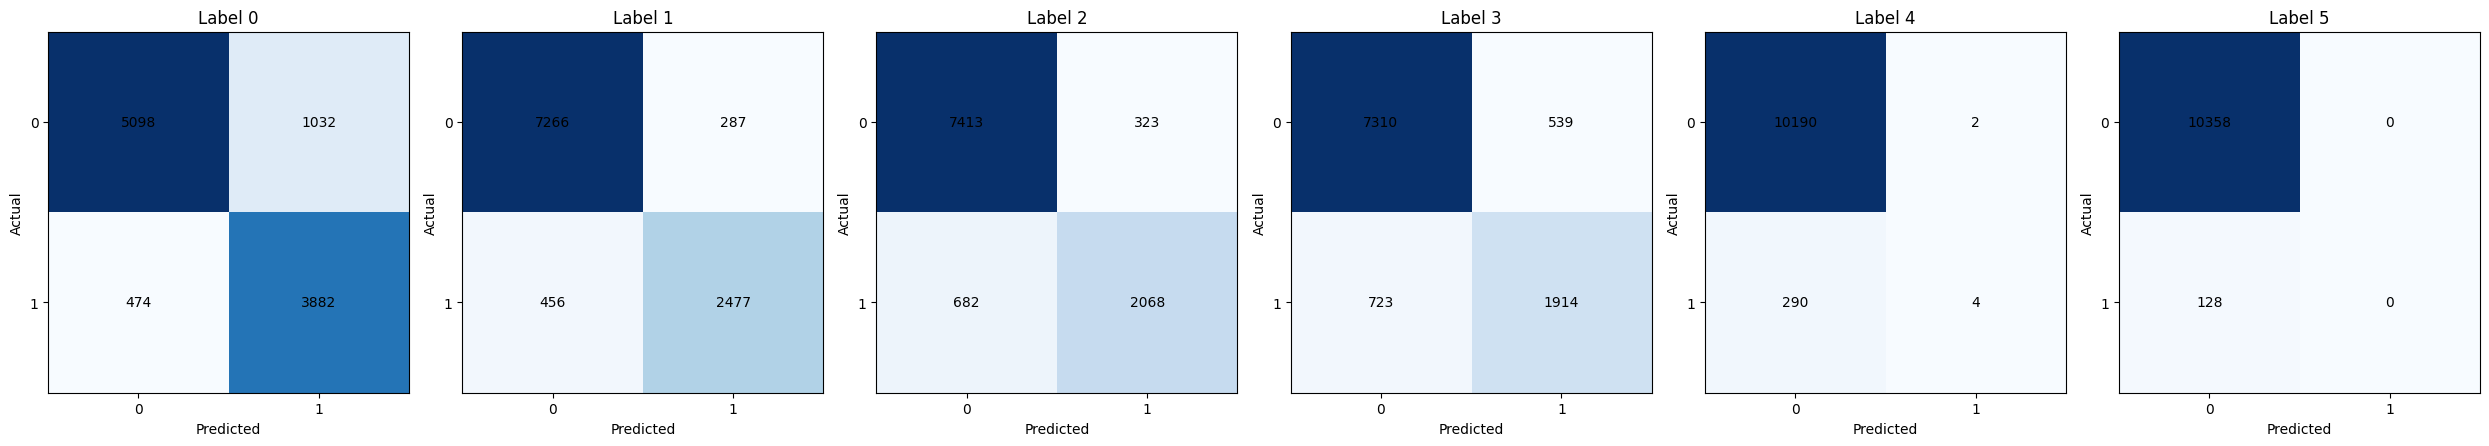

--------------
--------------
Results of ANN with Word2Vec embeddings
Exact Match Ratio: 0.6694
Hamming Loss: 0.0785
Recall: 0.8225
Precision: 0.8351
F1 Score: 0.8120


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


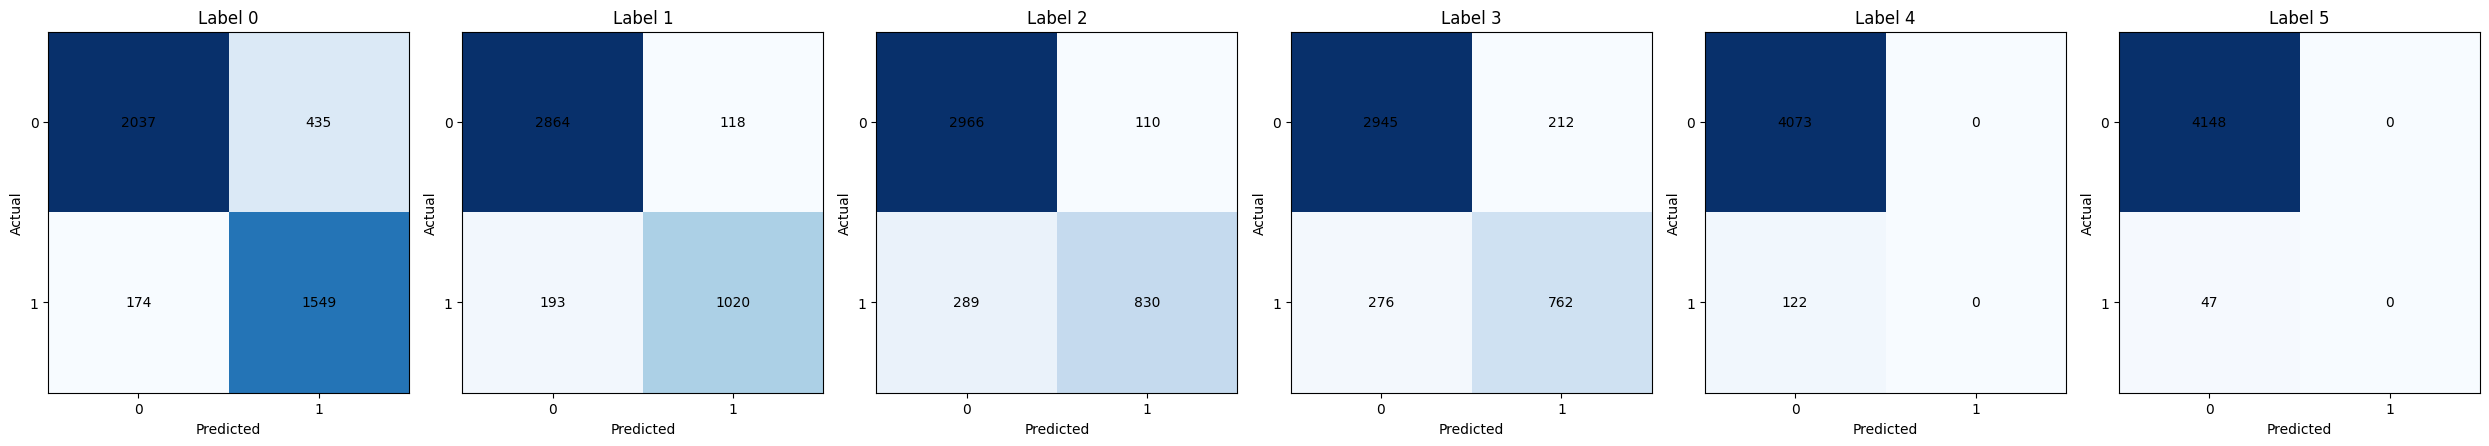

--------------
--------------
Results of ANN with Word2Vec embeddings
Exact Match Ratio: 0.6597
Hamming Loss: 0.0797
Recall: 0.8161
Precision: 0.8343
F1 Score: 0.8073


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


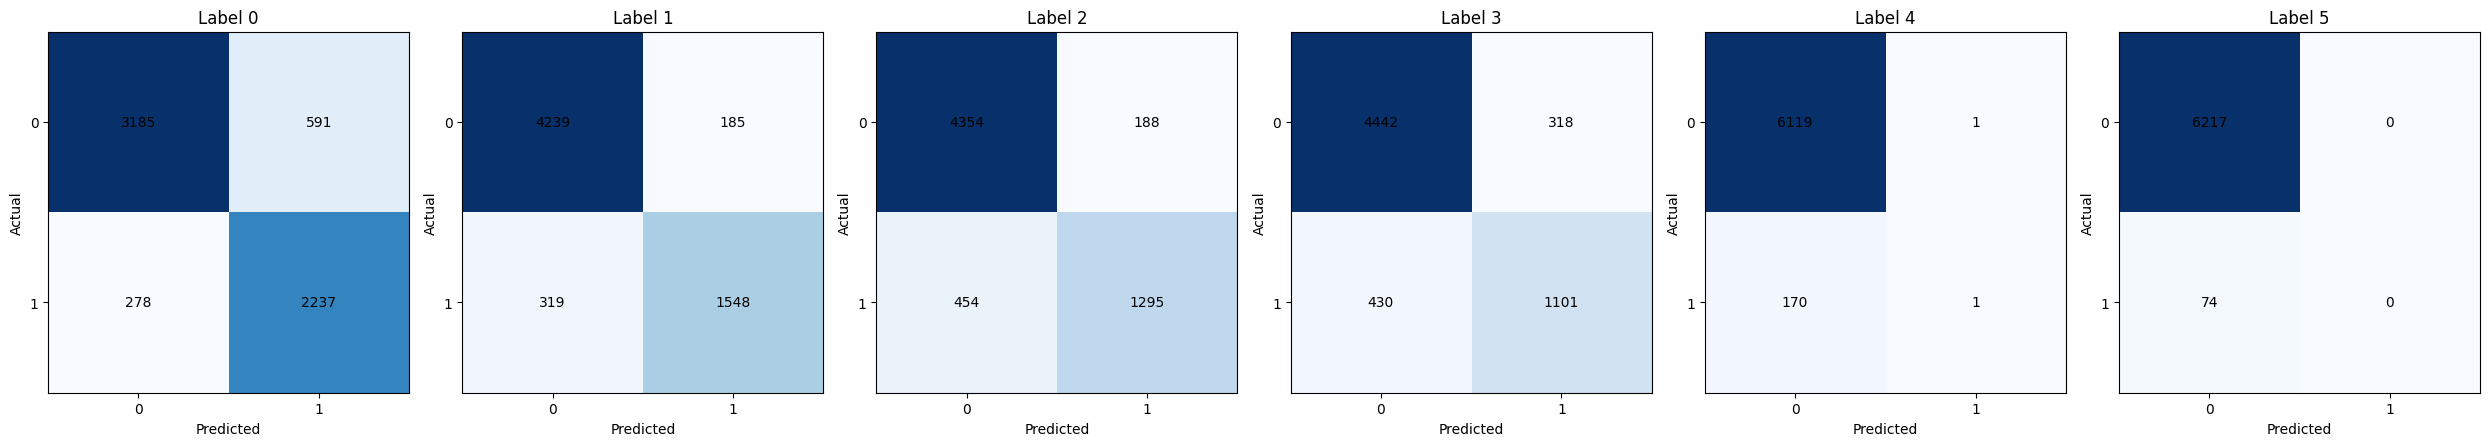

--------------


In [ ]:
# Run Evaluation
embedding_model="Word2Vec"
y_train_pred, y_train_true = Results(model_ann, train_dataloader, criterion,model_name="ANN",type="train", embedding_model=embedding_model, device=device)
y_val_pred,y_val_true = Results(model_ann, val_dataloader, criterion,model_name="ANN",type="validation", embedding_model=embedding_model, device=device)
y_test_pred, y_test_true = Results(model_ann, test_dataloader, criterion,model_name="ANN",embedding_model=embedding_model,type="test", device=device)

TestMultiLabel(y_train_true, y_train_pred,embedding_model=embedding_model,model_name="ANN")
TestMultiLabel(y_val_true, y_val_pred,embedding_model=embedding_model,model_name="ANN")
TestMultiLabel(y_test_true, y_test_pred,embedding_model=embedding_model,model_name="ANN")

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [106]:
from gensim.models import FastText
from nltk.tokenize import word_tokenize
# Tokenize text into words
train_tokens = X_train.apply(word_tokenize).tolist()

# Train FastText model
fastText_model = FastText(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)

In [107]:
def get_average_fastText(text, model, vec_size=100):
    words = text.split()
    vectorized_words = [model.wv[word] for word in words if word in model.wv]
    if not vectorized_words:
        return np.zeros(vec_size)
    avg_vector = np.mean(vectorized_words, axis=0)
    return avg_vector

X_train1_fastText = np.array([get_average_fastText(text, fastText_model, 100) for text in X_train1])
X_val1_fastText = np.array([get_average_fastText(text, fastText_model, 100) for text in X_val1])
X_test1_fastText = np.array([get_average_fastText(text, fastText_model, 100) for text in X_test1])

print("fast Text representation shape:", X_train1_fastText.shape)

fast Text representation shape: (10486, 100)


In [108]:

X_train_tensor = torch.tensor(X_train1_fastText, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train1, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val1_fastText, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val1, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test1_fastText, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test1, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [109]:

model_ann = ANNModel(100, 128, 6).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_ann.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model_ann.train()
    total_loss = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        output = model_ann(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    model_ann.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            output_val = model_ann(X_val_batch)
            loss_val = criterion(output_val, y_val_batch)
            total_val_loss += loss_val.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_dataloader):.4f}, Val Loss: {total_val_loss/len(val_dataloader):.4f}")



Epoch [1/10], Train Loss: 0.2654, Val Loss: 0.2202
Epoch [2/10], Train Loss: 0.2143, Val Loss: 0.2125
Epoch [3/10], Train Loss: 0.2078, Val Loss: 0.2064
Epoch [4/10], Train Loss: 0.2043, Val Loss: 0.2045
Epoch [5/10], Train Loss: 0.2013, Val Loss: 0.2035
Epoch [6/10], Train Loss: 0.1991, Val Loss: 0.2017
Epoch [7/10], Train Loss: 0.1972, Val Loss: 0.2005
Epoch [8/10], Train Loss: 0.1955, Val Loss: 0.1993
Epoch [9/10], Train Loss: 0.1945, Val Loss: 0.2014
Epoch [10/10], Train Loss: 0.1930, Val Loss: 0.1991


ANN with Fast Text embeddings train loss is 0.19207436532327316
ANN with Fast Text embeddings validation loss is 0.19909762275038342
ANN with Fast Text embeddings test loss is 0.1977323460473022
Training Results:
--------------
Results of ANN with Fast Text embeddings
Exact Match Ratio: 0.6544
Hamming Loss: 0.0804
Recall: 0.8116
Precision: 0.8276
F1 Score: 0.8019


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


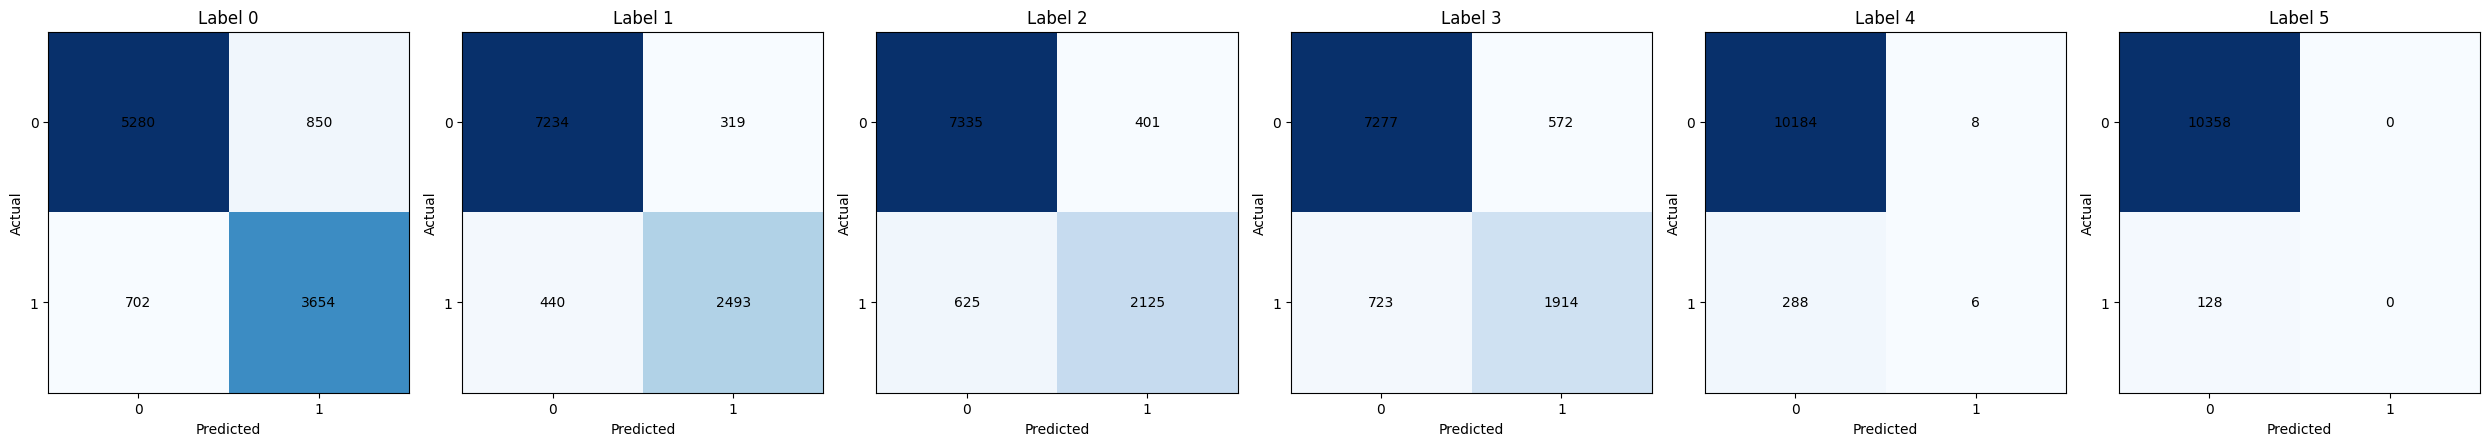

--------------
Validation Results:
--------------
Results of ANN with Fast Text embeddings
Exact Match Ratio: 0.6563
Hamming Loss: 0.0811
Recall: 0.8104
Precision: 0.8282
F1 Score: 0.8021


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


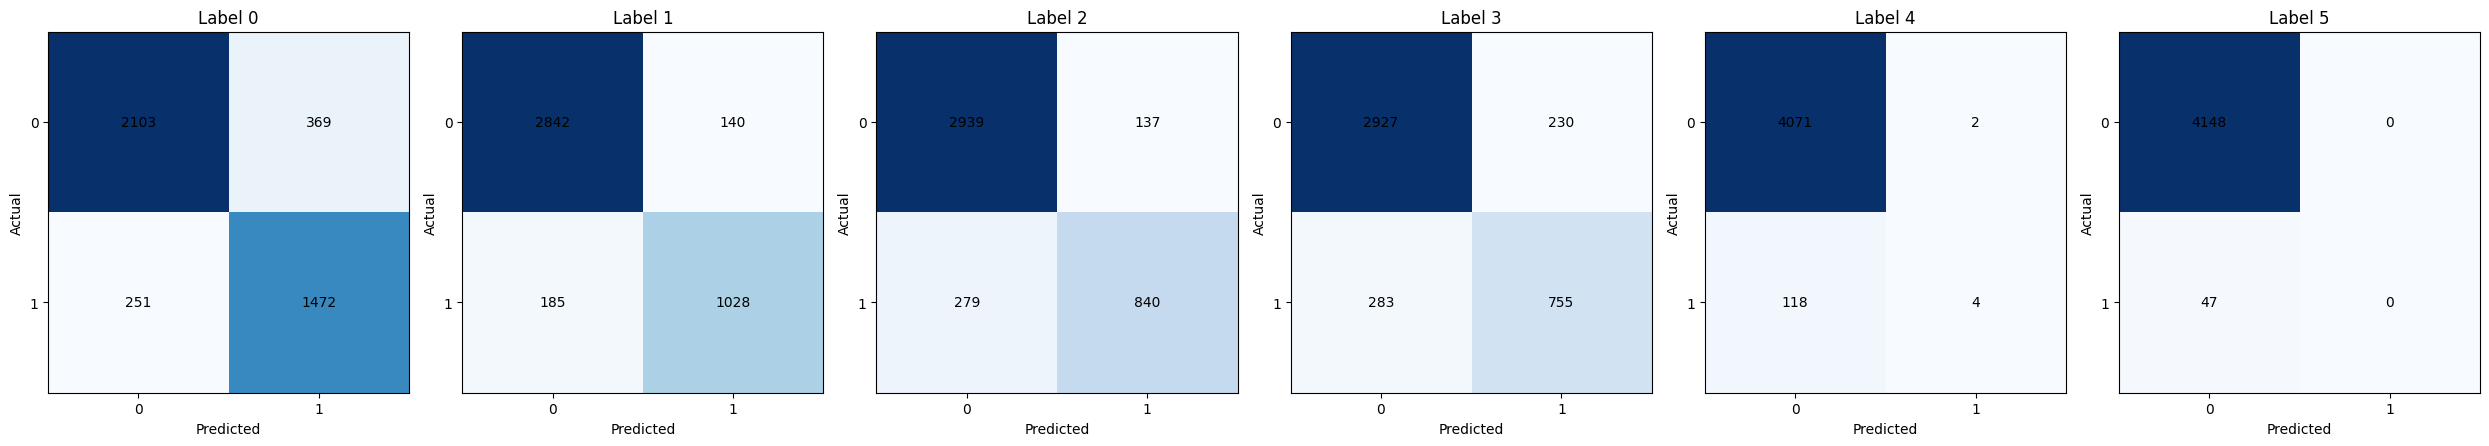

--------------
Test Results:
--------------
Results of ANN with Fast Text embeddings
Exact Match Ratio: 0.6508
Hamming Loss: 0.0820
Recall: 0.8108
Precision: 0.8281
F1 Score: 0.8015


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


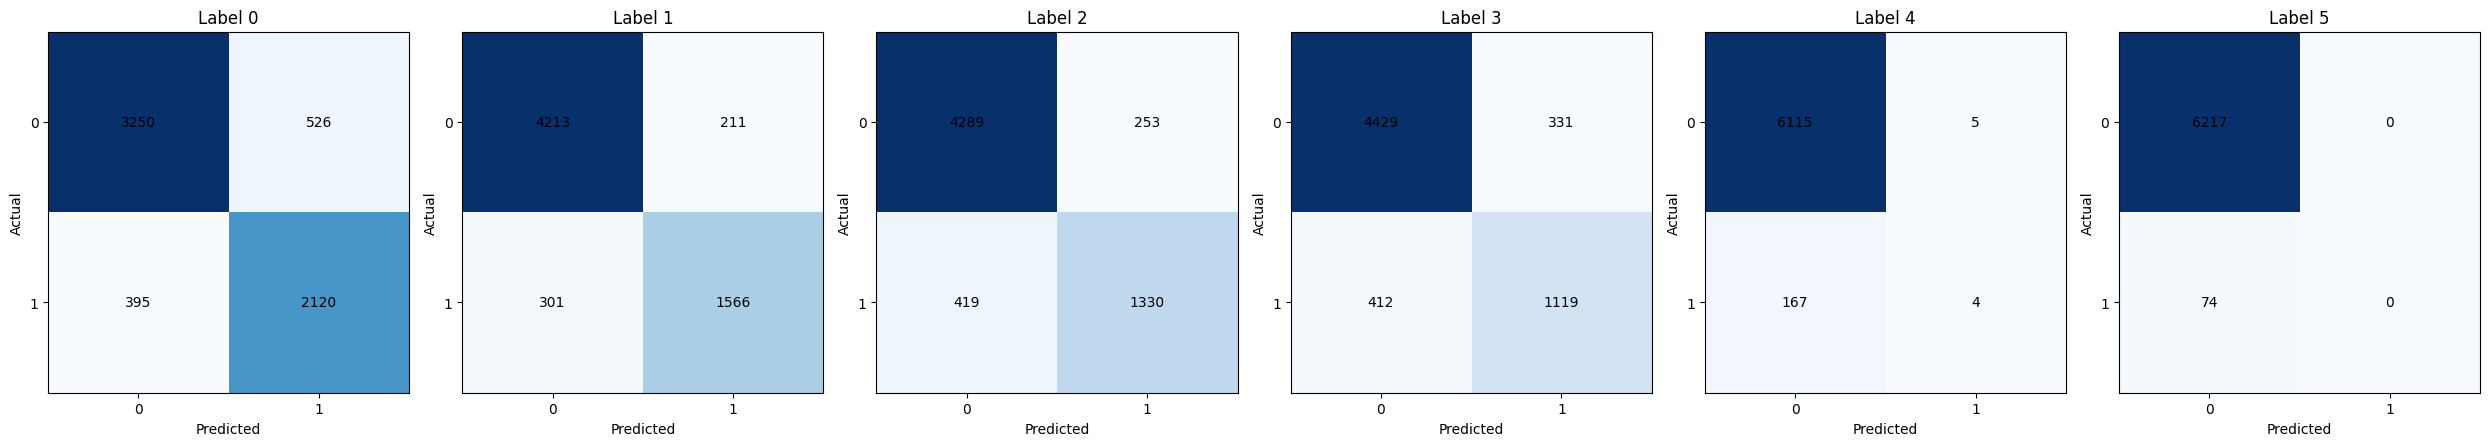

--------------


In [112]:
# Run Evaluation
embedding_model="Fast Text"
y_train_pred, y_train_true = Results(model_ann, train_dataloader, criterion,model_name="ANN",type="train", embedding_model=embedding_model, device=device)
y_val_pred,y_val_true = Results(model_ann, val_dataloader, criterion,model_name="ANN",type="validation", embedding_model=embedding_model, device=device)
y_test_pred, y_test_true = Results(model_ann, test_dataloader, criterion,model_name="ANN",embedding_model=embedding_model,type="test", device=device)
print('Training Results:')
TestMultiLabel(y_train_true, y_train_pred,embedding_model=embedding_model,model_name="ANN")
print('Validation Results:')
TestMultiLabel(y_val_true, y_val_pred,embedding_model=embedding_model,model_name="ANN")
print('Test Results:')
TestMultiLabel(y_test_true, y_test_pred,embedding_model=embedding_model,model_name="ANN")

# Model 3 : GRU

### (i) Word2Vec Embeddings

In [ ]:

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

def Word2VecModel(X_train):
  # Tokenize the text data
  tokenized_train_texts = [text.split() for text in X_train]
  word2vec_model = Word2Vec(
      sentences=tokenized_train_texts,
      vector_size=100,            # what dimensions should the vector be of
      window=5,                   # Context window size
      min_count=2,
      sg=1                         # Use skip-gram (sg=1)
  )
  return word2vec_model
word2vec_model=Word2VecModel(X_train1)

In [ ]:

from torch.utils.data import Dataset
import numpy as np
import torch

class EmbeddingDataset(Dataset):
    def __init__(self, textdata, labels, word2vec_model, vec_size=100, max_len=100):
        self.xTrain = textdata
        self.vec_size = vec_size
        self.yTrain = labels
        self.model = word2vec_model
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.xTrain.iloc[idx]
        words = text.split()
        vectorized_words = [self.model.wv[word] for word in words if word in self.model.wv]
        if not vectorized_words:
            vectorized_words = [np.zeros(self.vec_size)]

        vectorized_words = torch.tensor(vectorized_words, dtype=torch.float32)

        if len(vectorized_words) < self.max_len:
            pad_size = self.max_len - len(vectorized_words)
            padding = torch.zeros((pad_size, self.vec_size))
            vectorized_words = torch.cat([vectorized_words, padding], dim=0)
        else:
            vectorized_words = vectorized_words[:self.max_len]

        currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)

        return vectorized_words, currlabel

    def __len__(self):
        return len(self.xTrain)

train_dataset = EmbeddingDataset(X_train1,y_train1, word2vec_model)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)

val_dataset = EmbeddingDataset(X_val1,y_val1, word2vec_model)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = EmbeddingDataset(X_test1,y_test1, word2vec_model)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class GRUClassiferModel(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=128, output_dim=6, num_layers=2):
        super(GRUClassiferModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.fc(x)
        out = self.sigmoid(x)
        return out

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = GRUClassiferModel(100, 128, 6, 3).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 10

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_train_loss = 0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation Phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for X_val, y_val in val_dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            output_val = model(X_val)
            loss_val = criterion(output_val, y_val)
            total_val_loss += loss_val.item()

    avg_val_loss = total_val_loss / len(val_dataloader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

cuda


<ipython-input-31-779dac088c8d>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  vectorized_words = torch.tensor(vectorized_words, dtype=torch.float32)


Epoch [1/10], Train Loss: 0.2873, Val Loss: 0.2322
Epoch [2/10], Train Loss: 0.2223, Val Loss: 0.2060
Epoch [3/10], Train Loss: 0.2020, Val Loss: 0.2050
Epoch [4/10], Train Loss: 0.1917, Val Loss: 0.2041
Epoch [5/10], Train Loss: 0.1810, Val Loss: 0.2178
Epoch [6/10], Train Loss: 0.1716, Val Loss: 0.2271
Epoch [7/10], Train Loss: 0.1629, Val Loss: 0.2165
Epoch [8/10], Train Loss: 0.1531, Val Loss: 0.2225
Epoch [9/10], Train Loss: 0.1444, Val Loss: 0.2312
Epoch [10/10], Train Loss: 0.1334, Val Loss: 0.2381


GRU with Word2Vec embeddings train loss is 0.1280383569438283
GRU with Word2Vec embeddings validation loss is 0.2381044885877407
GRU with Word2Vec embeddings test loss is 0.24449233755920874
--------------
Results of GRU with Word2Vec embeddings
Exact Match Ratio: 0.7513
Hamming Loss: 0.0511
Recall: 0.8860
Precision: 0.9031
F1 Score: 0.8792


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


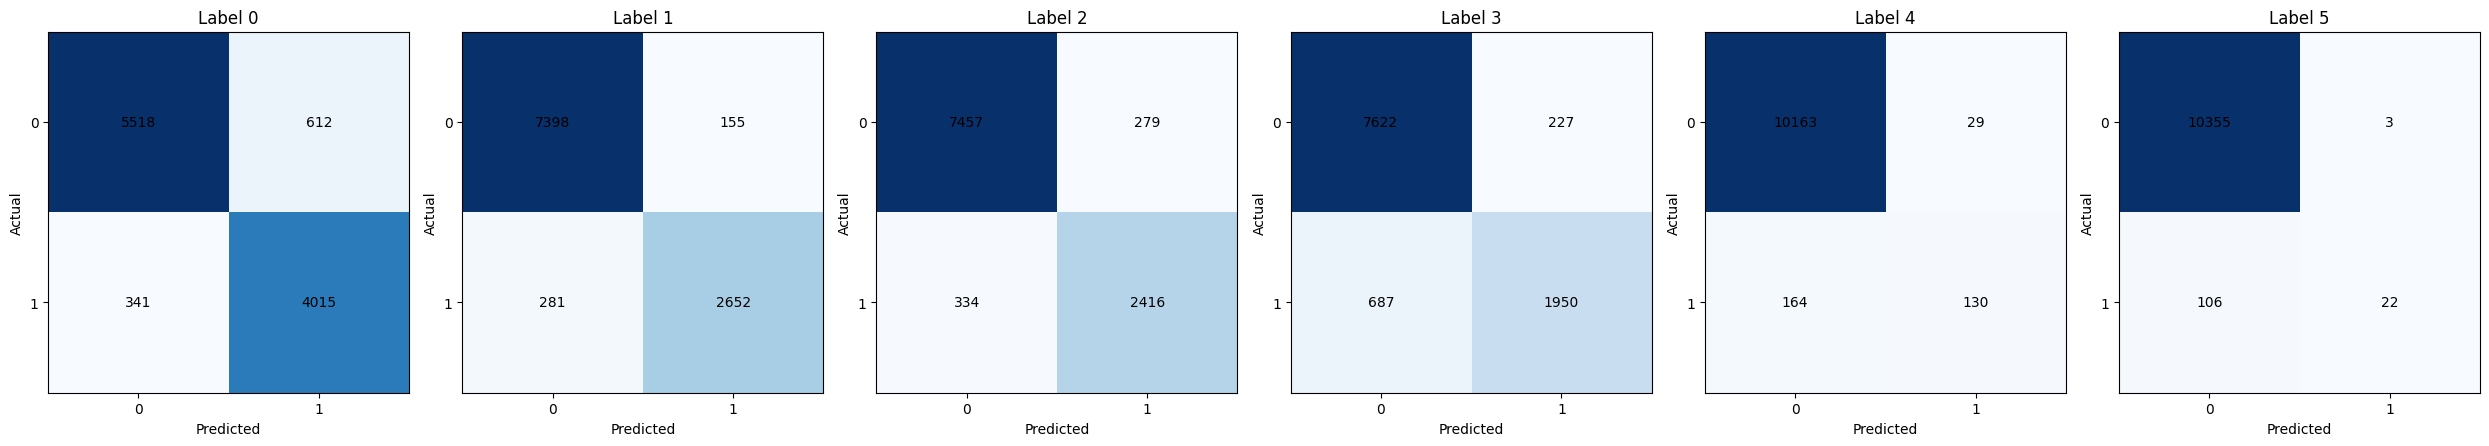

--------------
--------------
Results of GRU with Word2Vec embeddings
Exact Match Ratio: 0.6393
Hamming Loss: 0.0865
Recall: 0.8085
Precision: 0.8248
F1 Score: 0.7980


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


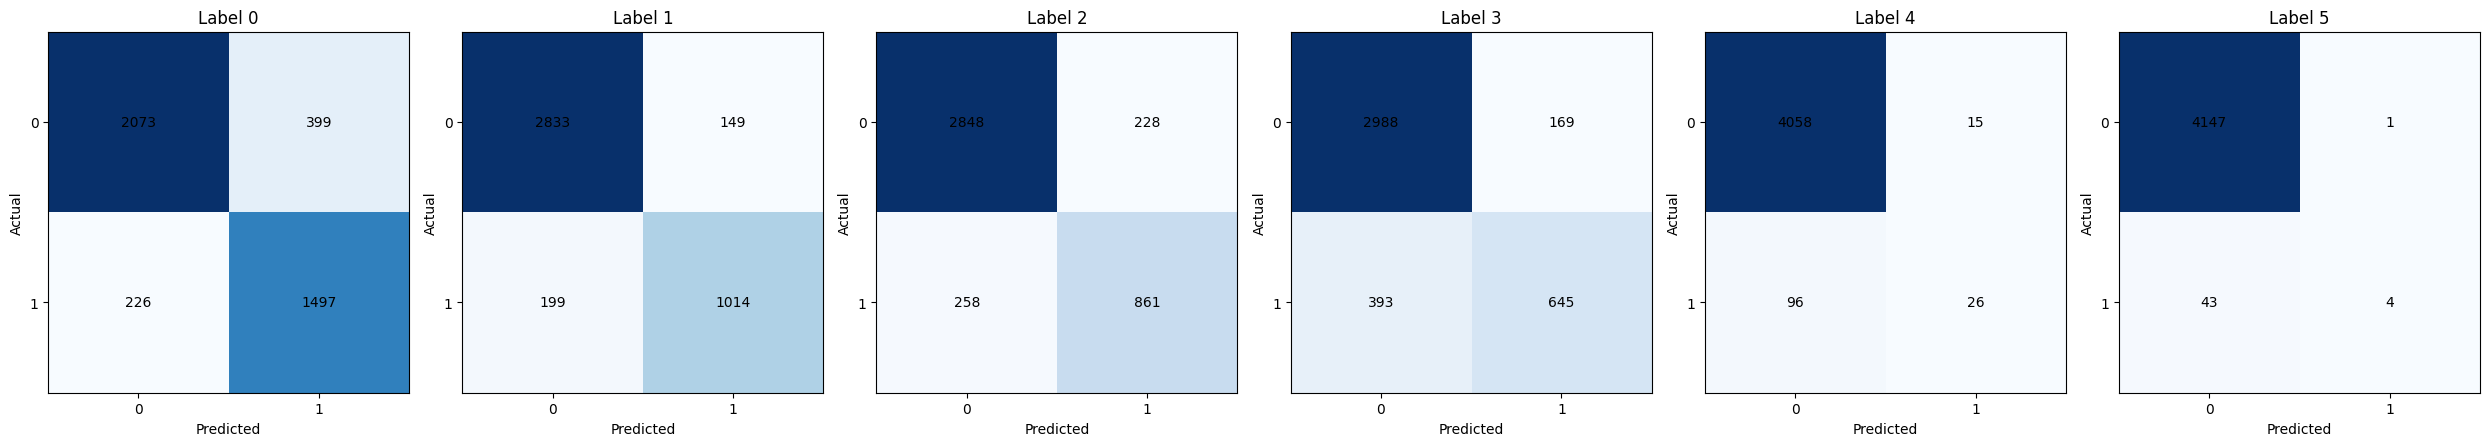

--------------
--------------
Results of GRU with Word2Vec embeddings
Exact Match Ratio: 0.6279
Hamming Loss: 0.0891
Recall: 0.7987
Precision: 0.8180
F1 Score: 0.7892


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


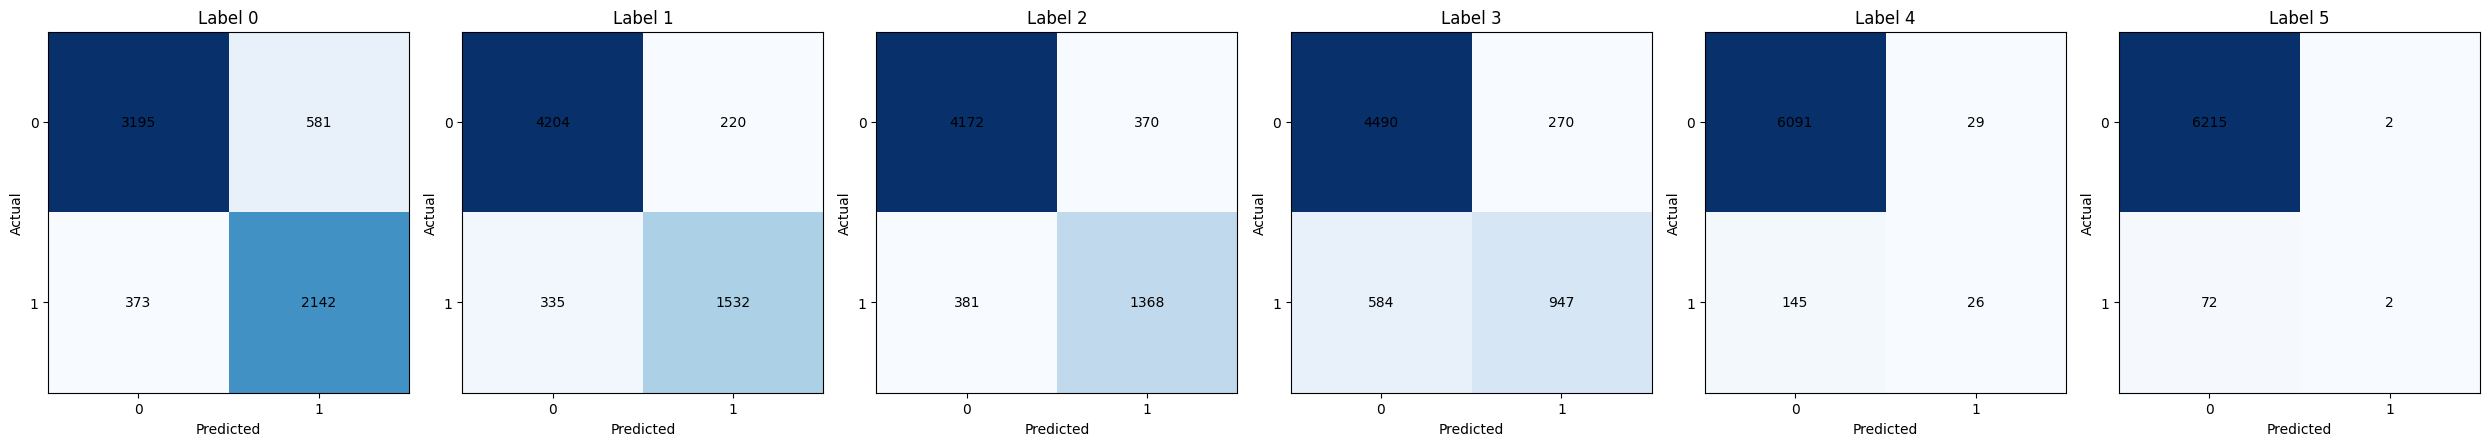

--------------


In [ ]:
# Run Evaluation
model_name="GRU"
embedding_model="Word2Vec"
y_train_pred, y_train_true = Results(model, train_dataloader, criterion,model_name,embedding_model,type="train", device=device)
y_val_pred,y_val_true = Results(model, val_dataloader, criterion,model_name,embedding_model,type="validation", device=device)
y_test_pred, y_test_true = Results(model, test_dataloader, criterion,model_name,embedding_model,type="test", device=device)

TestMultiLabel(y_train_true, y_train_pred,embedding_model,model_name)
TestMultiLabel(y_val_true, y_val_pred,embedding_model,model_name)
TestMultiLabel(y_test_true, y_test_pred,embedding_model,model_name)

### (ii) FastText Embeddings

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch

class EmbeddingDataset(Dataset):
    def __init__(self, textdata, labels, word2vec_model, vec_size=100, max_len=100):
        self.xTrain = textdata
        self.vec_size = vec_size
        self.yTrain = labels
        self.model = word2vec_model
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.xTrain.iloc[idx]
        words = text.split()
        vectorized_words = [self.model.wv[word] for word in words if word in self.model.wv]
        if not vectorized_words:
            vectorized_words = [np.zeros(self.vec_size)]

        vectorized_words = torch.tensor(vectorized_words, dtype=torch.float32)

        if len(vectorized_words) < self.max_len:
            pad_size = self.max_len - len(vectorized_words)
            padding = torch.zeros((pad_size, self.vec_size))
            vectorized_words = torch.cat([vectorized_words, padding], dim=0)
        else:
            vectorized_words = vectorized_words[:self.max_len]

        currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)

        return vectorized_words, currlabel

    def __len__(self):
        return len(self.xTrain)


In [ ]:
from gensim.models import FastText
from gensim.utils import simple_preprocess

def FastTextModel(X_train):
  # Tokenize the text data
  tokenized_train_texts = [text.split() for text in X_train]
  fasttext_model = FastText(
      sentences=tokenized_train_texts,
      vector_size=100,            # what dimensions should the vector be of
      window=5,                   # Context window size
      min_count=2,
      sg=1                         # Use skip-gram (sg=1)
  )
  return fasttext_model
fasttext_model = FastTextModel(X_train1)
train_dataset = EmbeddingDataset(X_train1,y_train1, fasttext_model)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)

val_dataset = EmbeddingDataset(X_val1,y_val1, fasttext_model)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = EmbeddingDataset(X_test1,y_test1, fasttext_model)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = GRUClassiferModel(100, 128, 6, 3).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 10

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_train_loss = 0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation Phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for X_val, y_val in val_dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            output_val = model(X_val)
            loss_val = criterion(output_val, y_val)
            total_val_loss += loss_val.item()

    avg_val_loss = total_val_loss / len(val_dataloader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

cuda


<ipython-input-20-bb1ab16f9bb3>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  vectorized_words = torch.tensor(vectorized_words, dtype=torch.float32)


Epoch [1/10], Train Loss: 0.3268, Val Loss: 0.2471
Epoch [2/10], Train Loss: 0.2345, Val Loss: 0.2247
Epoch [3/10], Train Loss: 0.2078, Val Loss: 0.2063
Epoch [4/10], Train Loss: 0.1991, Val Loss: 0.2009
Epoch [5/10], Train Loss: 0.1909, Val Loss: 0.1953
Epoch [6/10], Train Loss: 0.1829, Val Loss: 0.2020
Epoch [7/10], Train Loss: 0.1769, Val Loss: 0.2097
Epoch [8/10], Train Loss: 0.1708, Val Loss: 0.2048
Epoch [9/10], Train Loss: 0.1664, Val Loss: 0.2025
Epoch [10/10], Train Loss: 0.1586, Val Loss: 0.2116


GRU with FastText embeddings train loss is 0.15605420378468385
GRU with FastText embeddings validation loss is 0.2115501533403541
GRU with FastText embeddings test loss is 0.21346328400000178
--------------
Results of GRU with FastText embeddings
Exact Match Ratio: 0.7112
Hamming Loss: 0.0624
Recall: 0.8678
Precision: 0.8811
F1 Score: 0.8573


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


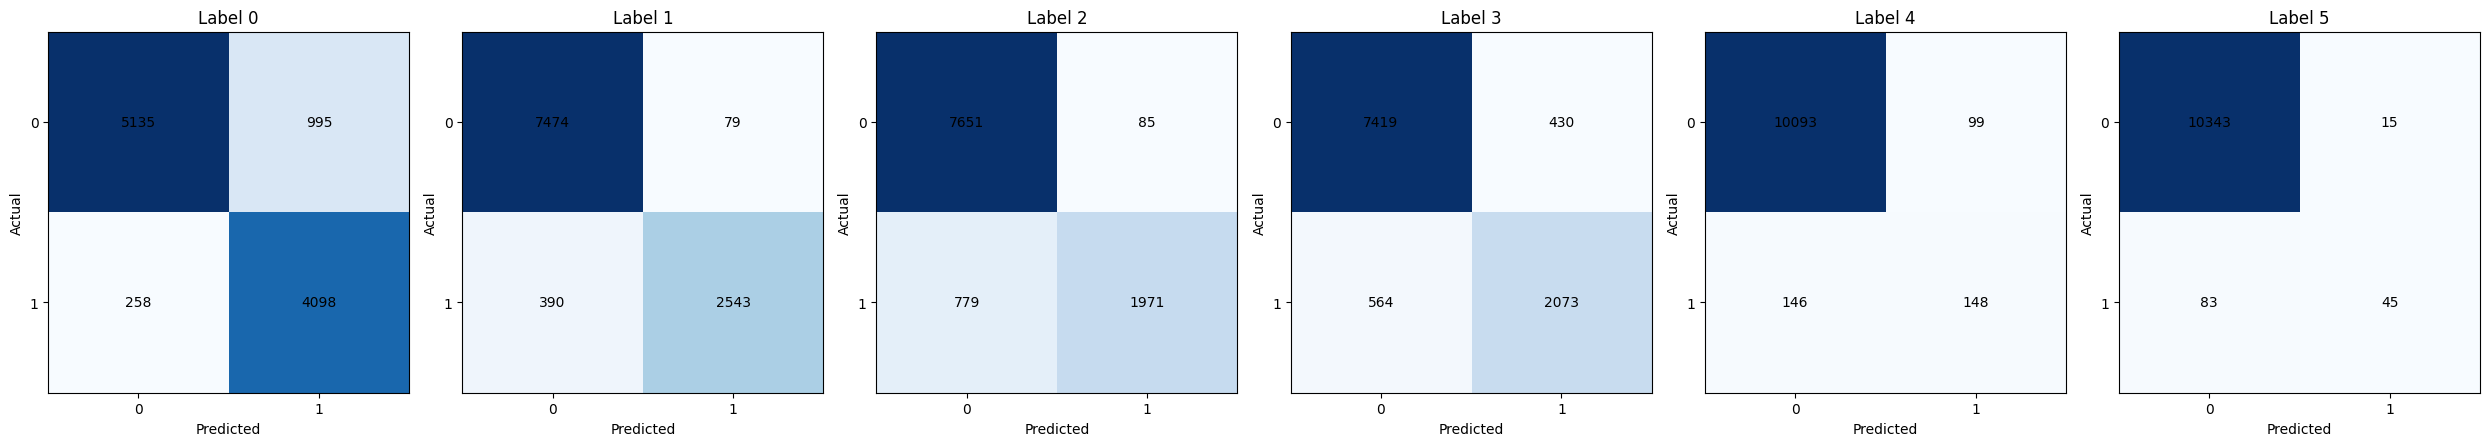

--------------
--------------
Results of GRU with FastText embeddings
Exact Match Ratio: 0.6570
Hamming Loss: 0.0810
Recall: 0.8259
Precision: 0.8379
F1 Score: 0.8136


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


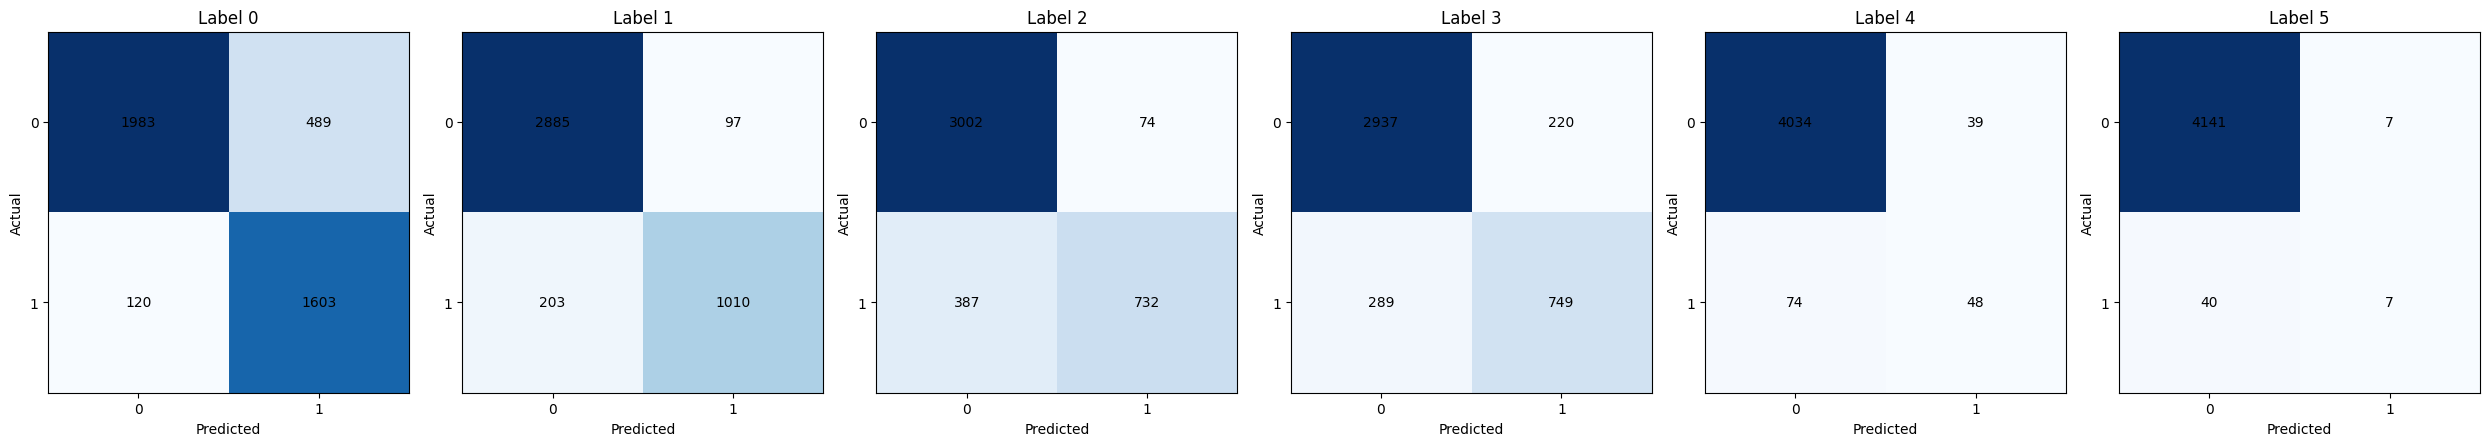

--------------
--------------
Results of GRU with FastText embeddings
Exact Match Ratio: 0.6500
Hamming Loss: 0.0823
Recall: 0.8188
Precision: 0.8351
F1 Score: 0.8083


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


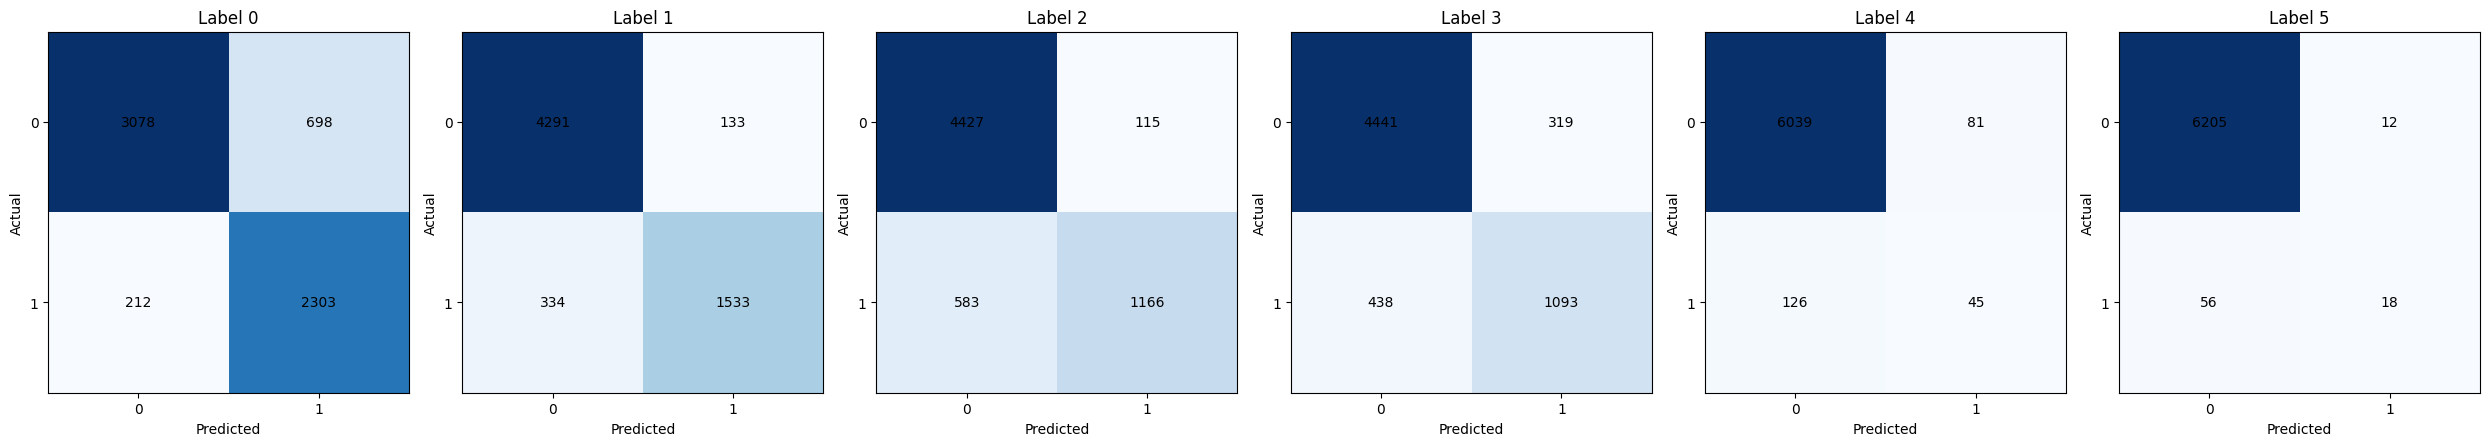

--------------


In [ ]:
# Run Evaluation
model_name="GRU"
embedding_model="FastText"
y_train_pred, y_train_true = Results(model, train_dataloader, criterion,model_name,embedding_model,type="train", device=device)
y_val_pred,y_val_true = Results(model, val_dataloader, criterion,model_name,embedding_model,type="validation", device=device)
y_test_pred, y_test_true = Results(model, test_dataloader, criterion,model_name,embedding_model,type="test", device=device)

TestMultiLabel(y_train_true, y_train_pred,embedding_model,model_name)
TestMultiLabel(y_val_true, y_val_pred,embedding_model,model_name)
TestMultiLabel(y_test_true, y_test_pred,embedding_model,model_name)

# Model 4: Bidirectional LSTM

### (i) Word2Vec Embeddings

In [ ]:

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

def Word2VecModel(X_train):
  # Tokenize the text data
  tokenized_train_texts = [text.split() for text in X_train]
  word2vec_model = Word2Vec(
      sentences=tokenized_train_texts,
      vector_size=100,            # what dimensions should the vector be of
      window=5,                   # Context window size
      min_count=2,
      sg=1                         # Use skip-gram (sg=1)
  )
  return word2vec_model
word2vec_model=Word2VecModel(X_train1)

In [ ]:

from torch.utils.data import Dataset
import numpy as np
import torch

train_dataset = EmbeddingDataset(X_train1,y_train1, word2vec_model)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)

val_dataset = EmbeddingDataset(X_val1,y_val1, word2vec_model)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = EmbeddingDataset(X_test1,y_test1, word2vec_model)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class BiLSTMClassiferModel(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=128, output_dim=6, num_layers=2):
        super(BiLSTMClassiferModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.bilstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        out = self.sigmoid(x)
        return out

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = BiLSTMClassiferModel(100, 128, 6, 3).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 10

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_train_loss = 0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation Phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for X_val, y_val in val_dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            output_val = model(X_val)
            loss_val = criterion(output_val, y_val)
            total_val_loss += loss_val.item()

    avg_val_loss = total_val_loss / len(val_dataloader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

cuda
Epoch [1/10], Train Loss: 0.4124, Val Loss: 0.3292
Epoch [2/10], Train Loss: 0.2782, Val Loss: 0.2521
Epoch [3/10], Train Loss: 0.2380, Val Loss: 0.2317
Epoch [4/10], Train Loss: 0.2196, Val Loss: 0.2132
Epoch [5/10], Train Loss: 0.2076, Val Loss: 0.2083
Epoch [6/10], Train Loss: 0.2009, Val Loss: 0.2052
Epoch [7/10], Train Loss: 0.1940, Val Loss: 0.2071
Epoch [8/10], Train Loss: 0.1886, Val Loss: 0.2053
Epoch [9/10], Train Loss: 0.1812, Val Loss: 0.2053
Epoch [10/10], Train Loss: 0.1752, Val Loss: 0.2073


BiLSTM with Word2Vec embeddings train loss is 0.16680460623124752
BiLSTM with Word2Vec embeddings validation loss is 0.2072880816730586
BiLSTM with Word2Vec embeddings test loss is 0.20991451752306234
--------------
Results of BiLSTM with Word2Vec embeddings
Exact Match Ratio: 0.6875
Hamming Loss: 0.0684
Recall: 0.8413
Precision: 0.8534
F1 Score: 0.8301


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


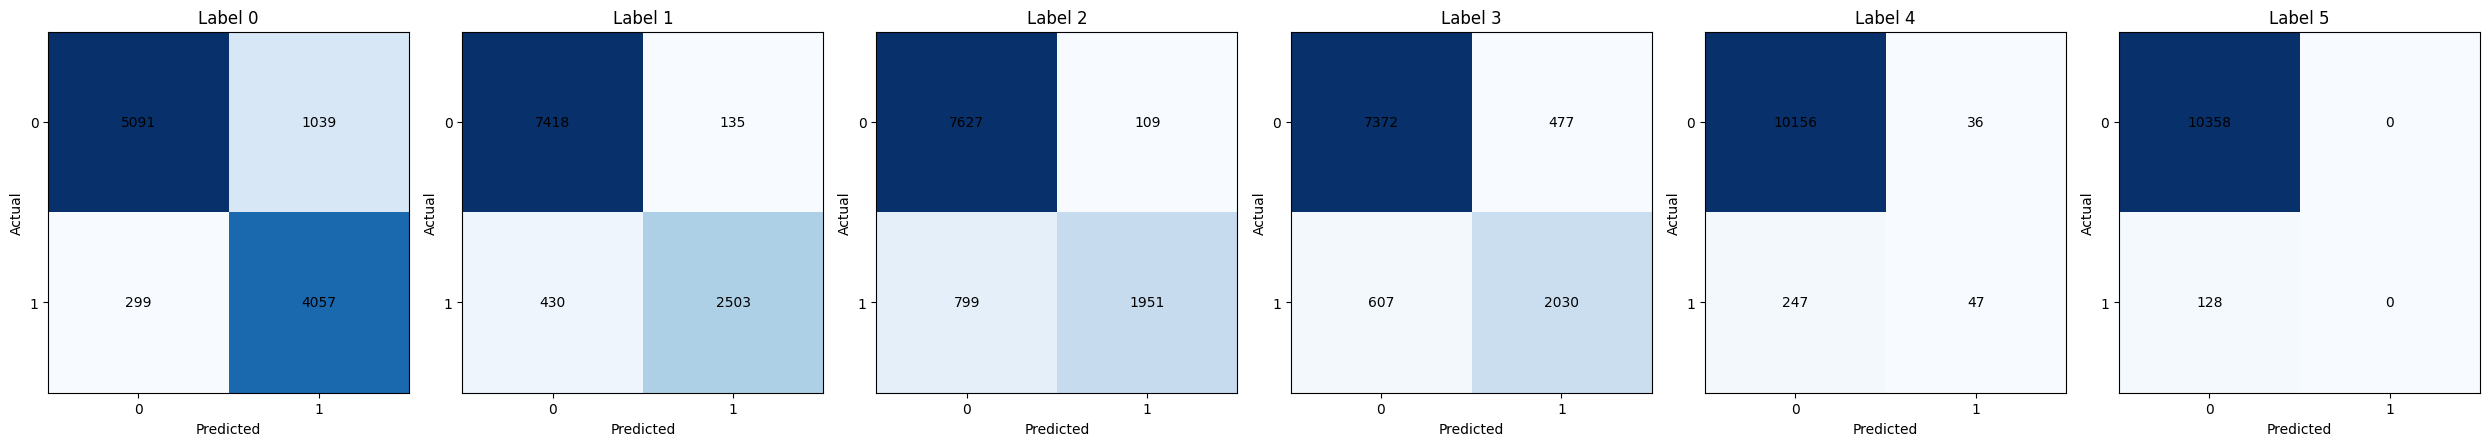

--------------
--------------
Results of BiLSTM with Word2Vec embeddings
Exact Match Ratio: 0.6455
Hamming Loss: 0.0828
Recall: 0.8082
Precision: 0.8201
F1 Score: 0.7962


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


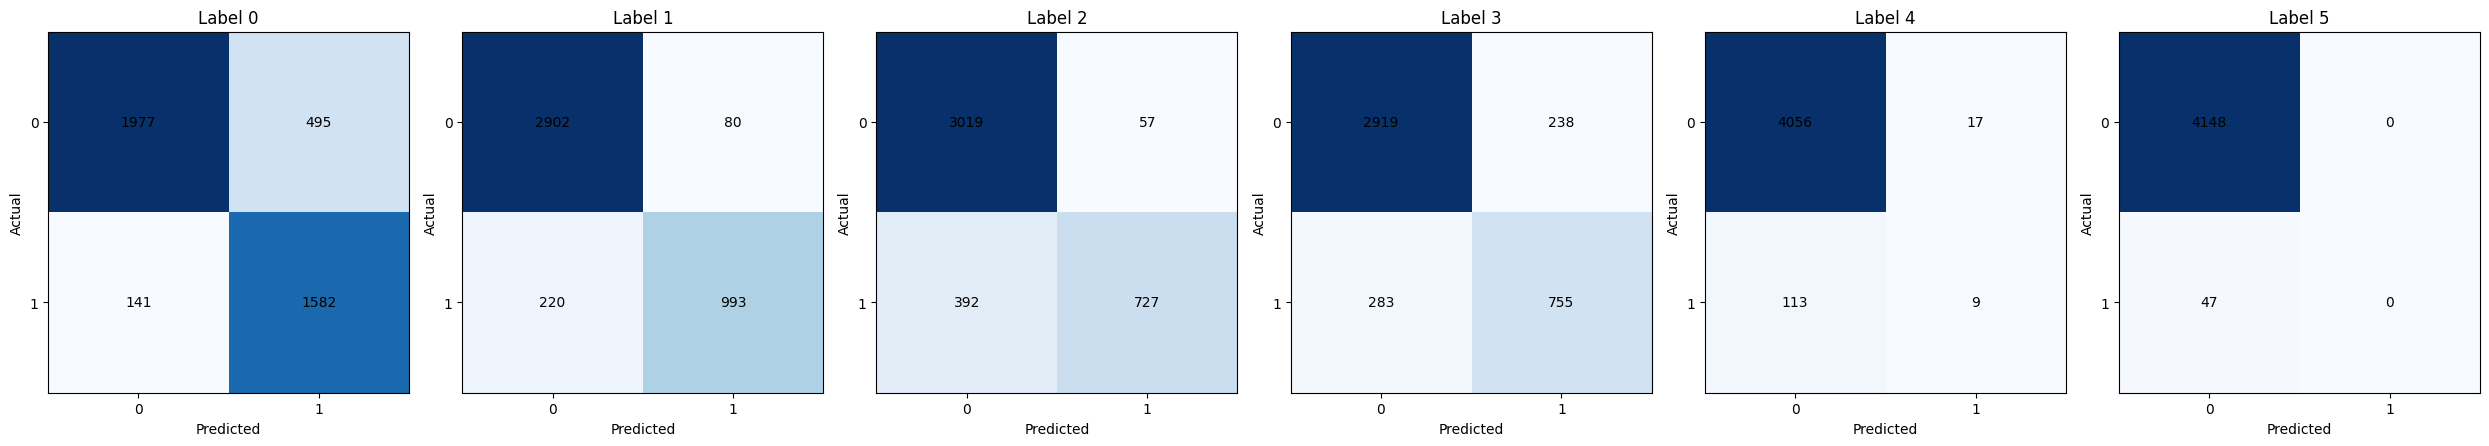

--------------
--------------
Results of BiLSTM with Word2Vec embeddings
Exact Match Ratio: 0.6388
Hamming Loss: 0.0832
Recall: 0.8072
Precision: 0.8195
F1 Score: 0.7945


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


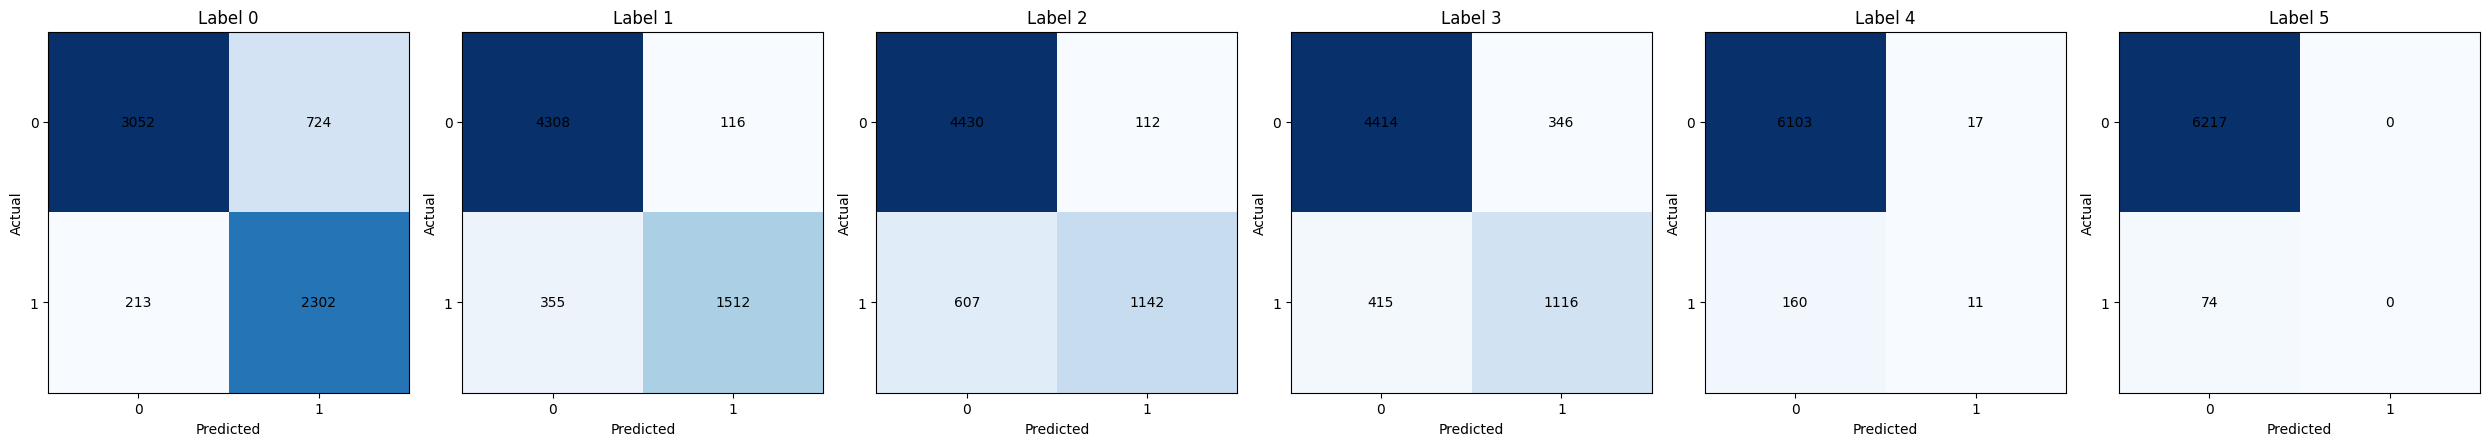

--------------


In [ ]:
# Run Evaluation
model_name="BiLSTM"
embedding_model="Word2Vec"
y_train_pred, y_train_true = Results(model, train_dataloader, criterion,model_name,embedding_model,type="train", device=device)
y_val_pred,y_val_true = Results(model, val_dataloader, criterion,model_name,embedding_model,type="validation", device=device)
y_test_pred, y_test_true = Results(model, test_dataloader, criterion,model_name,embedding_model,type="test", device=device)

TestMultiLabel(y_train_true, y_train_pred,embedding_model,model_name)
TestMultiLabel(y_val_true, y_val_pred,embedding_model,model_name)
TestMultiLabel(y_test_true, y_test_pred,embedding_model,model_name)

### (ii) FastText Embeddings

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch

class EmbeddingDataset(Dataset):
    def __init__(self, textdata, labels, word2vec_model, vec_size=100, max_len=100):
        self.xTrain = textdata
        self.vec_size = vec_size
        self.yTrain = labels
        self.model = word2vec_model
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.xTrain.iloc[idx]
        words = text.split()
        vectorized_words = [self.model.wv[word] for word in words if word in self.model.wv]
        if not vectorized_words:
            vectorized_words = [np.zeros(self.vec_size)]

        vectorized_words = torch.tensor(vectorized_words, dtype=torch.float32)

        if len(vectorized_words) < self.max_len:
            pad_size = self.max_len - len(vectorized_words)
            padding = torch.zeros((pad_size, self.vec_size))
            vectorized_words = torch.cat([vectorized_words, padding], dim=0)
        else:
            vectorized_words = vectorized_words[:self.max_len]

        currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)

        return vectorized_words, currlabel

    def __len__(self):
        return len(self.xTrain)


In [ ]:
from gensim.models import FastText
from gensim.utils import simple_preprocess

def FastTextModel(X_train):
  # Tokenize the text data
  tokenized_train_texts = [text.split() for text in X_train]
  fasttext_model = FastText(
      sentences=tokenized_train_texts,
      vector_size=100,            # what dimensions should the vector be of
      window=5,                   # Context window size
      min_count=2,
      sg=1                         # Use skip-gram (sg=1)
  )
  return fasttext_model
fasttext_model = FastTextModel(X_train1)
train_dataset = EmbeddingDataset(X_train1,y_train1, fasttext_model)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)

val_dataset = EmbeddingDataset(X_val1,y_val1, fasttext_model)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = EmbeddingDataset(X_test1,y_test1, fasttext_model)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = BiLSTMClassiferModel(100, 128, 6, 3).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 10

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_train_loss = 0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation Phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for X_val, y_val in val_dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            output_val = model(X_val)
            loss_val = criterion(output_val, y_val)
            total_val_loss += loss_val.item()

    avg_val_loss = total_val_loss / len(val_dataloader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

cuda
Epoch [1/10], Train Loss: 0.3891, Val Loss: 0.2946
Epoch [2/10], Train Loss: 0.2752, Val Loss: 0.2563
Epoch [3/10], Train Loss: 0.2369, Val Loss: 0.2262
Epoch [4/10], Train Loss: 0.2146, Val Loss: 0.2057
Epoch [5/10], Train Loss: 0.2021, Val Loss: 0.2036
Epoch [6/10], Train Loss: 0.1944, Val Loss: 0.2022
Epoch [7/10], Train Loss: 0.1859, Val Loss: 0.2020
Epoch [8/10], Train Loss: 0.1800, Val Loss: 0.2041
Epoch [9/10], Train Loss: 0.1741, Val Loss: 0.2065
Epoch [10/10], Train Loss: 0.1686, Val Loss: 0.2081


BiLSTM with FastText embeddings train loss is 0.1644823584796452
BiLSTM with FastText embeddings validation loss is 0.20807108689438214
BiLSTM with FastText embeddings test loss is 0.20920809787331204
--------------
Results of BiLSTM with FastText embeddings
Exact Match Ratio: 0.6930
Hamming Loss: 0.0672
Recall: 0.8508
Precision: 0.8624
F1 Score: 0.8392


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


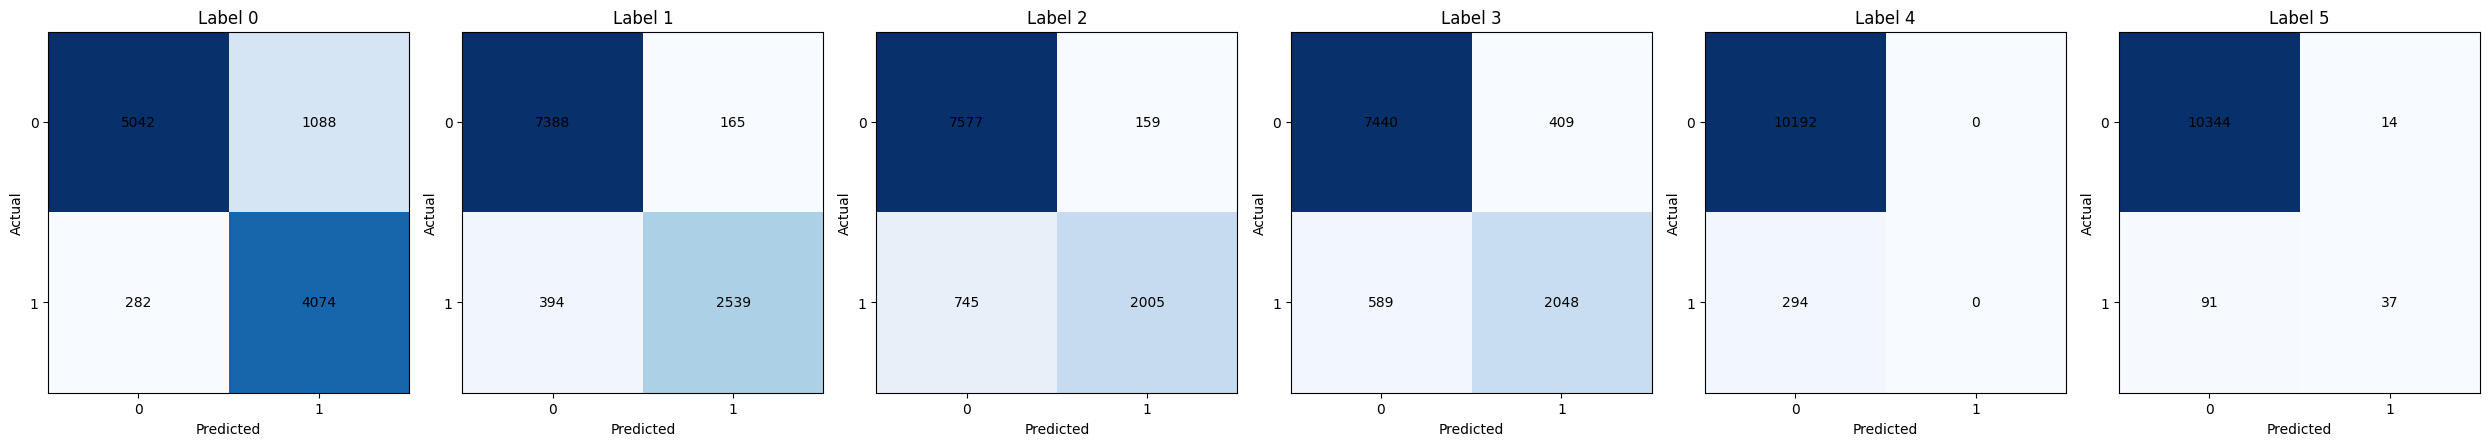

--------------
--------------
Results of BiLSTM with FastText embeddings
Exact Match Ratio: 0.6548
Hamming Loss: 0.0819
Recall: 0.8174
Precision: 0.8335
F1 Score: 0.8077


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


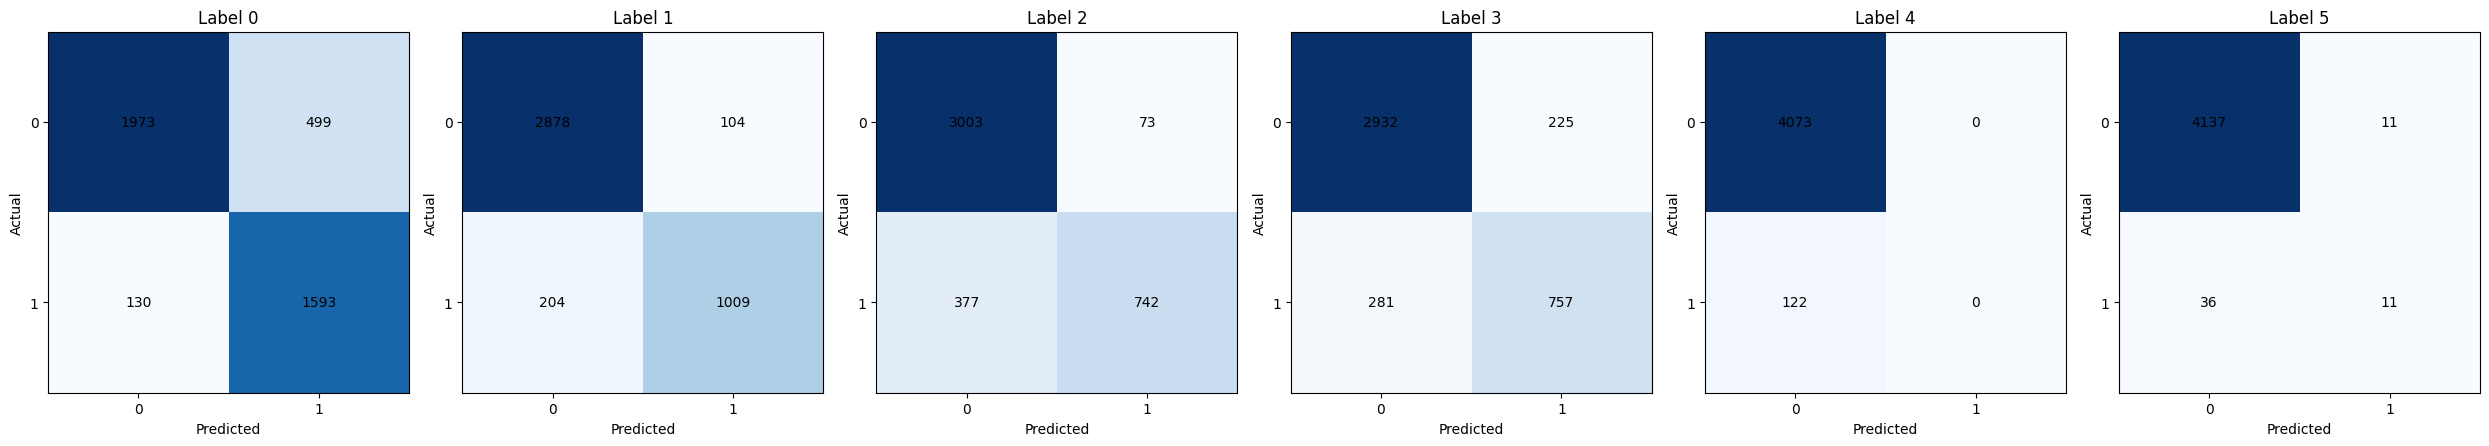

--------------
--------------
Results of BiLSTM with FastText embeddings
Exact Match Ratio: 0.6476
Hamming Loss: 0.0822
Recall: 0.8170
Precision: 0.8303
F1 Score: 0.8053


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


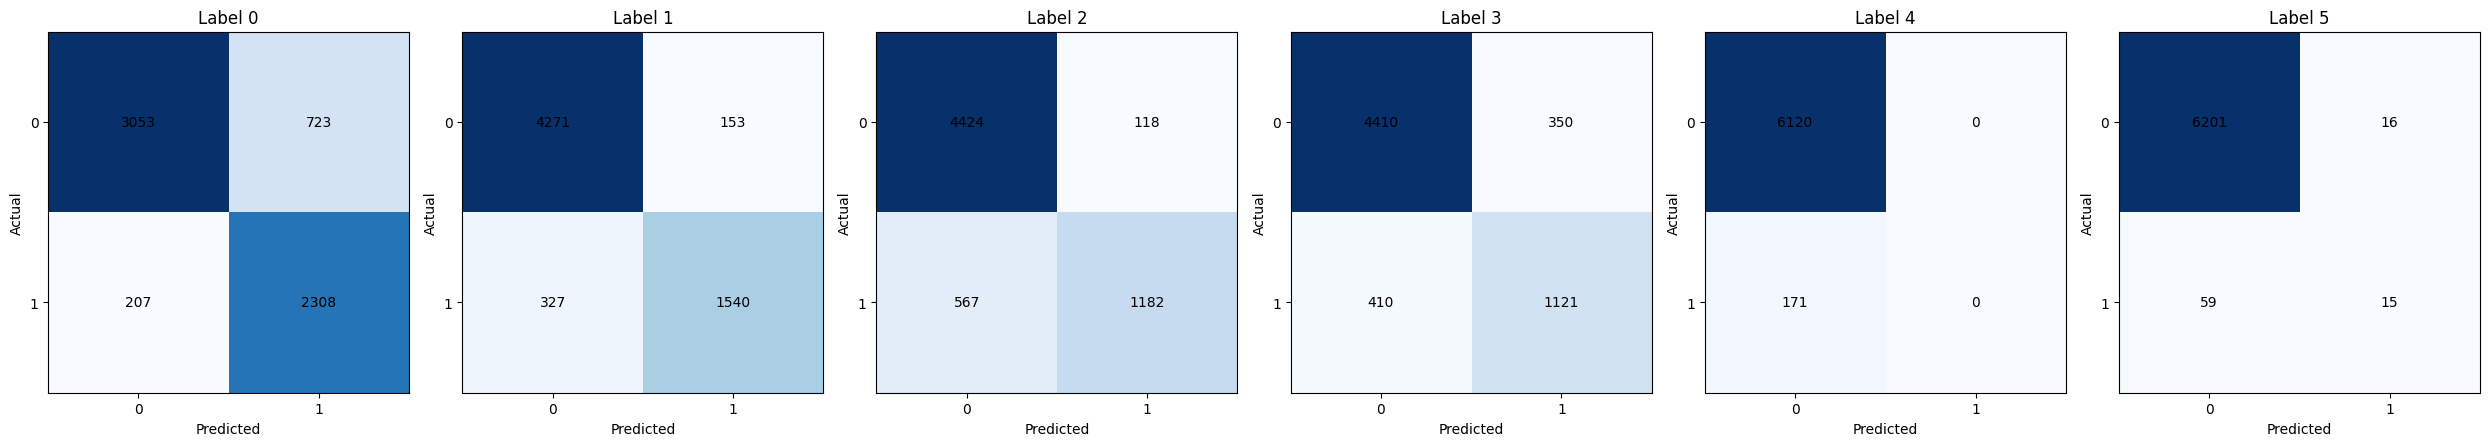

--------------


In [ ]:
# Run Evaluation
model_name="BiLSTM"
embedding_model="FastText"
y_train_pred, y_train_true = Results(model, train_dataloader, criterion,model_name,embedding_model,type="train", device=device)
y_val_pred,y_val_true = Results(model, val_dataloader, criterion,model_name,embedding_model,type="validation", device=device)
y_test_pred, y_test_true = Results(model, test_dataloader, criterion,model_name,embedding_model,type="test", device=device)

TestMultiLabel(y_train_true, y_train_pred,embedding_model,model_name)
TestMultiLabel(y_val_true, y_val_pred,embedding_model,model_name)
TestMultiLabel(y_test_true, y_test_pred,embedding_model,model_name)

## Dataset - 2

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


In [ ]:
# Download stopwords if not already available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ai21btech11012/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
file_path = 'sample_data/A2D2.xlsx'
df = pd.read_excel(file_path)
df.head()

,ID,Content,Domain
0,1,engali Binodiini Ekti Natir Putul Chaalchitro ...,Entertainment
1,2,ChiefsAholic A Wolf In Chiefs Clothing articl...,Entertainment
2,3,Kabandha Your Rating Write a review Optional C...,Entertainment
3,4,In Bruges 2008 R 1h 47m IMDb RATING 79 10 474K...,Entertainment
4,5,Men in Black 2012 PG13 1h 46m IMDb RATING 68 1...,Entertainment


In [ ]:
# Check for missing values,  class imbalance, and other issues.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       3927 non-null   int64 
 1   Content  3927 non-null   object
 2   Domain   3927 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.2+ KB
None


In [ ]:
# Check the unique labels and their counts
df['Domain'].value_counts()

Domain
Technology       1474
Healthcare        913
Entertainment     636
Tourism           562
Sports            342
Name: count, dtype: int64

## Data Preprocessing
Now that we know this is a multi-class classification problem and NOT multi-label classification problem, we :-
1. Use the process_text function defined above for processing text
2. Create and encode labels
3. Split data into train-val-test sets

In [ ]:
def process_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    new_processed_text = ' '.join(words)
    return new_processed_text

In [ ]:
df["Processed_Content"] = df["Content"].apply(process_text)
df.head()

,ID,Content,Domain,Processed_Content
0,1,engali Binodiini Ekti Natir Putul Chaalchitro ...,Entertainment,engali binodiini ekti natir putul chaalchitro ...
1,2,ChiefsAholic A Wolf In Chiefs Clothing articl...,Entertainment,chiefsaholic wolf chiefs clothing articleshowc...
2,3,Kabandha Your Rating Write a review Optional C...,Entertainment,kabandha rating write review optional characte...
3,4,In Bruges 2008 R 1h 47m IMDb RATING 79 10 474K...,Entertainment,bruges 2008 r 1h 47m imdb rating 79 10 474k ra...
4,5,Men in Black 2012 PG13 1h 46m IMDb RATING 68 1...,Entertainment,men black 2012 pg13 1h 46m imdb rating 68 10 3...


In [ ]:
df["Label"] = df["Domain"].astype("category").cat.codes
label_mapping = dict(enumerate(df["Domain"].astype("category").cat.categories))
print(label_mapping)

{0: 'Entertainment', 1: 'Healthcare', 2: 'Sports', 3: 'Technology', 4: 'Tourism'}


In [ ]:
# Split into Train and Test sets
train_texts, val_and_test_texts, train_labels, val_and_test_labels = train_test_split(
    df["Processed_Content"], df["Label"], test_size=0.5, random_state=42, stratify=df["Label"]
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    val_and_test_texts, val_and_test_labels, test_size=0.4, random_state=42, stratify=val_and_test_labels
)

In [ ]:
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 1963, Validation size: 1178, Test size: 786


## Feature extraction/Representation
Convert text data (titles and abstracts) into numerical representations
1. Bag of Words (BoW)
2. TF-IDF (Term Frequency-Inverse Document Frequency)
3. Word Embeddings (Word2Vec, FastText)

- We will be using **TF-IDF** since it is known to work well with text classification using *Classical ML models*.
- Among word embeddings, we would experiment with **Word2Vec** and **FastText** for *Deep Learning models*.

In [ ]:
y_test=test_df["label"].values
y_train=train_df["label"].values
y_val=val_df["label"].values

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ai21btech11012/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# 1. Use BoW representation
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=5000)  # Keep only top 5000 words

X_train_bow = bow_vectorizer.fit_transform(train_df["text"])
X_val_bow = bow_vectorizer.transform(val_df["text"])
X_test_bow = bow_vectorizer.transform(test_df["text"])

print("BoW representation shape:", X_train_bow.shape)

BoW representation shape: (1963, 5000)


In [ ]:
# 2. TF-IDF
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["text"])
X_val_tfidf = tfidf_vectorizer.transform(val_df["text"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["text"])

# Print shape to confirm
print("TF-IDF Shape:", X_train_tfidf.shape)

TF-IDF Shape: (1963, 5000)


In [ ]:
from gensim.models import Word2Vec

# Tokenize text into words
train_tokens = train_df["text"].apply(word_tokenize).tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)

from gensim.models import FastText

# Train FastText model
fasttext_model = FastText(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def EvalMetricsMultiClass(y_true, y_pred,classes=5):
    class_names = ['Entertainment', 'Healthcare', 'Sports', 'Technology', 'Tourism']

    accuracy = accuracy_score(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    precision = class_report['macro avg']['precision']
    recall = class_report['macro avg']['recall']
    f1 = class_report['macro avg']['f1-score']

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    print("\nClassification Report:")
    for class_name in class_names:
        metrics = class_report[class_name]
        print(f"{class_name}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-score={metrics['f1-score']:.2f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
def get_average_word2vec(text, model, vector_size=100):
    """
        Convert text into a single averaged word vector.
        Used as input to classical ML models which expects fixed length input

        Args:
        - text (str): Input sentence or document.
        - model (Word2Vec): Trained Word2Vec model.
        - vector_size (int): Size of word vectors.

        Returns:
        - numpy array of shape (vector_size,)
                                                                                """
    tokens = word_tokenize(text)  # Tokenize text
    vectors = [model.wv[word] for word in tokens if word in model.wv]  # Get vectors if word exists
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)  # Average or return zero vector



def get_word_embeddings(text, model, vector_size=100):
    """
    Convert text into a sequence of word embeddings.

        Args:
        - text (str): Input sentence or document.
        - model (Word2Vec): Trained Word2Vec model.
        - vector_size (int): Size of word vectors.

        Returns:
        - List of numpy arrays (each of shape (vector_size,))
                                                                                                    """
    tokens = word_tokenize(text)
    embeddings = [model.wv[word] if word in model.wv else np.zeros(vector_size) for word in tokens]
    return embeddings

def get_average_word2vec(text, model, vec_size=100):
    words = text.split()
    vectorized_words = [model.wv[word] for word in words if word in model.wv]
    if not vectorized_words:
        return np.zeros(vec_size)
    avg_vector = np.mean(vectorized_words, axis=0)
    return avg_vector

X_train2_w2v = np.array([get_average_word2vec(text, word2vec_model, 100) for text in train_texts])
X_val2_w2v = np.array([get_average_word2vec(text, word2vec_model, 100) for text in val_texts])
X_test2_w2v = np.array([get_average_word2vec(text, word2vec_model, 100) for text in test_texts])

print("Word2Vec representation shape:", X_train2_w2v.shape)

def get_average_fasttext(text, model, vec_size=100):
    words = text.split()
    vectorized_words = [model.wv[word] for word in words if word in model.wv]
    if not vectorized_words:
        return np.zeros(vec_size)
    avg_vector = np.mean(vectorized_words, axis=0)
    return avg_vector

X_train2_fasttext = np.array([get_average_fasttext(text, fasttext_model, 100) for text in train_texts])
X_val2_fasttext = np.array([get_average_fasttext(text, fasttext_model, 100) for text in val_texts])
X_test2_fasttext = np.array([get_average_fasttext(text, fasttext_model, 100) for text in test_texts])

print("FastText representation shape:", X_train2_fasttext.shape)

Word2Vec representation shape: (1963, 100)
FastText representation shape: (1963, 100)


# Classical Machine Learning Approach

# Model 1 : Support Vector Classifier (SVC)


In [52]:
import numpy as np
import pandas as pd
import sklearn.metrics
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix

class SVCModel():
    def __init__(self, X_train, y_train):
        self.model = SVC(kernel='linear')
        self.X_train = X_train
        self.y_train = y_train

    def fit(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self, X_test):
        self.y_output = self.model.predict(X_test)
        return self.y_output

    def test(self, y_test,type='test'):
        print(f"SVC {type} accuracy:", accuracy_score(y_test, self.y_output))

### (i) BoW embeddings + SVC

----------
SVC with Bow embeddings
SVC train accuracy: 1.0
SVC validation accuracy: 0.9855687606112055
SVC test accuracy: 0.9809160305343512
Accuracy: 0.9809, Precision: 0.9833, Recall: 0.9845, F1-Score: 0.9838

Classification Report:
Entertainment: Precision=1.00, Recall=1.00, F1-score=1.00
Healthcare: Precision=0.96, Recall=0.97, F1-score=0.96
Sports: Precision=0.99, Recall=1.00, F1-score=0.99
Technology: Precision=0.98, Recall=0.98, F1-score=0.98
Tourism: Precision=0.99, Recall=0.97, F1-score=0.98


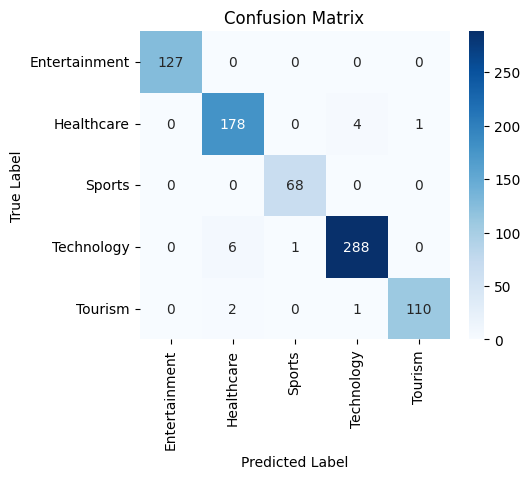

----------


In [ ]:

model_name='SVC'
embedding_model='Bow'


print('----------')
print(f'{model_name} with {embedding_model} embeddings')
svcModel=SVCModel(X_train_bow, y_train)
svcModel.fit()
y_svc=svcModel.predict(X_train_bow)
svcModel.test(y_train,'train')
y_svc=svcModel.predict(X_val_bow)
svcModel.test(y_val,'validation')
y_svc=svcModel.predict(X_test_bow)
svcModel.test(y_test,'test')
EvalMetricsMultiClass(y_test, y_svc, 5)
print('----------')

### (ii) TF-IDF embeddings + SVC

----------
SVC with TF-IDF embeddings
SVC train accuracy: 1.0
SVC validation accuracy: 0.9991511035653651
SVC test accuracy: 1.0
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000

Classification Report:
Entertainment: Precision=1.00, Recall=1.00, F1-score=1.00
Healthcare: Precision=1.00, Recall=1.00, F1-score=1.00
Sports: Precision=1.00, Recall=1.00, F1-score=1.00
Technology: Precision=1.00, Recall=1.00, F1-score=1.00
Tourism: Precision=1.00, Recall=1.00, F1-score=1.00


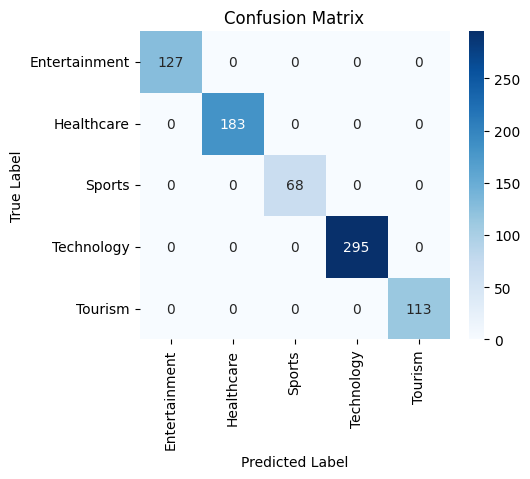

----------


In [54]:
model_name='SVC'
embedding_model='TF-IDF'

print('----------')
print(f'{model_name} with {embedding_model} embeddings')
svcModel=SVCModel(X_train_tfidf, y_train)
svcModel.fit()
y_svc=svcModel.predict(X_train_tfidf)
svcModel.test(y_train,'train')
y_svc=svcModel.predict(X_val_tfidf)
svcModel.test(y_val,'validation')
y_svc=svcModel.predict(X_test_tfidf)
svcModel.test(y_test,'test')
EvalMetricsMultiClass(y_test, y_svc, 5)
print('----------')

# Deep Learning 

# Model 2: Feed Forward Neural Network


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

### (i) word2vec embeddings

In [56]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train2_w2v, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val2_w2v, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(val_labels.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test2_w2v, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [57]:
model = ANNModel(100, 128, 5)
model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to('cuda:0'), y_batch.to('cuda:0')
        output = model(X_batch)
        y_batch = y_batch.long()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_accuracy = correct_train / total_train

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to('cuda:0'), y_val_batch.to('cuda:0')
            output_val = model(X_val_batch)
            y_val_batch = y_val_batch.long()
            loss_val = criterion(output_val, y_val_batch)
            total_val_loss += loss_val.item()
            _, output = torch.max(output_val, 1)
            correct_val += (output == y_val_batch).sum().item()
            total_val += y_val_batch.size(0)

    val_accuracy = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()
        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)
        correct_test += (predicted_test == y_test_batch).sum().item()
        total_test += y_test_batch.size(0)

test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch [1/10], Train Acc: 0.7855, Val Acc: 0.9032
Epoch [2/10], Train Acc: 0.9562, Val Acc: 0.9915
Epoch [3/10], Train Acc: 0.9908, Val Acc: 0.9941
Epoch [4/10], Train Acc: 0.9929, Val Acc: 0.9949
Epoch [5/10], Train Acc: 0.9934, Val Acc: 0.9958
Epoch [6/10], Train Acc: 0.9949, Val Acc: 0.9958
Epoch [7/10], Train Acc: 0.9939, Val Acc: 0.9958
Epoch [8/10], Train Acc: 0.9959, Val Acc: 0.9958
Epoch [9/10], Train Acc: 0.9964, Val Acc: 0.9966
Epoch [10/10], Train Acc: 0.9969, Val Acc: 0.9958
Test Accuracy: 0.9949


----------
ANN with word2vec embedding
Accuracy: 0.9949, Precision: 0.9955, Recall: 0.9942, F1-Score: 0.9948

Classification Report:
Entertainment: Precision=0.98, Recall=1.00, F1-score=0.99
Healthcare: Precision=1.00, Recall=0.99, F1-score=0.99
Sports: Precision=1.00, Recall=0.99, F1-score=0.99
Technology: Precision=0.99, Recall=1.00, F1-score=0.99
Tourism: Precision=1.00, Recall=1.00, F1-score=1.00


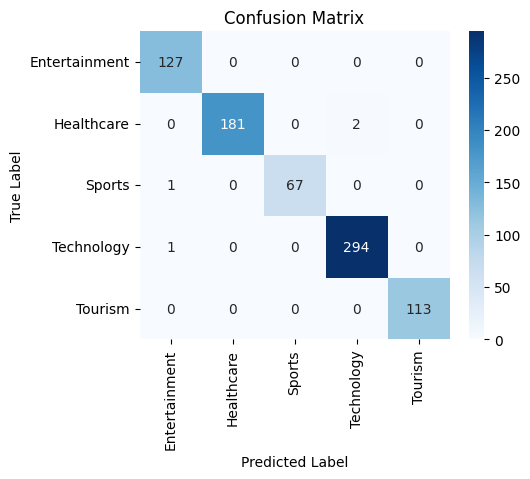

----------


In [58]:
# evaluating model
y_true = []
y_pred = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()

        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)

        y_true.extend(y_test_batch.cpu().numpy())
        y_pred.extend(predicted_test.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
print('----------')
print('ANN with word2vec embedding')
EvalMetricsMultiClass(y_true, y_pred,5)
print('----------')

### (ii) FastText Embedding

In [59]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train2_fasttext, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val2_fasttext, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(val_labels.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test2_fasttext, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [60]:
model = ANNModel(100, 128, 5)
model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to('cuda:0'), y_batch.to('cuda:0')
        output = model(X_batch)
        y_batch = y_batch.long()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_accuracy = correct_train / total_train

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to('cuda:0'), y_val_batch.to('cuda:0')
            output_val = model(X_val_batch)
            y_val_batch = y_val_batch.long()
            loss_val = criterion(output_val, y_val_batch)
            total_val_loss += loss_val.item()
            _, output = torch.max(output_val, 1)
            correct_val += (output == y_val_batch).sum().item()
            total_val += y_val_batch.size(0)

    val_accuracy = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()
        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)
        correct_test += (predicted_test == y_test_batch).sum().item()
        total_test += y_test_batch.size(0)

test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch [1/10], Train Acc: 0.7789, Val Acc: 0.9771
Epoch [2/10], Train Acc: 0.9842, Val Acc: 0.9941
Epoch [3/10], Train Acc: 0.9898, Val Acc: 0.9915
Epoch [4/10], Train Acc: 0.9908, Val Acc: 0.9915
Epoch [5/10], Train Acc: 0.9903, Val Acc: 0.9924
Epoch [6/10], Train Acc: 0.9924, Val Acc: 0.9949
Epoch [7/10], Train Acc: 0.9929, Val Acc: 0.9949
Epoch [8/10], Train Acc: 0.9949, Val Acc: 0.9966
Epoch [9/10], Train Acc: 0.9949, Val Acc: 0.9958
Epoch [10/10], Train Acc: 0.9949, Val Acc: 0.9958
Test Accuracy: 0.9936


----------
ANN with FastText embedding
Accuracy: 0.9936, Precision: 0.9940, Recall: 0.9913, F1-Score: 0.9926

Classification Report:
Entertainment: Precision=0.98, Recall=1.00, F1-score=0.99
Healthcare: Precision=1.00, Recall=0.99, F1-score=0.99
Sports: Precision=1.00, Recall=0.97, F1-score=0.99
Technology: Precision=0.99, Recall=1.00, F1-score=0.99
Tourism: Precision=1.00, Recall=1.00, F1-score=1.00


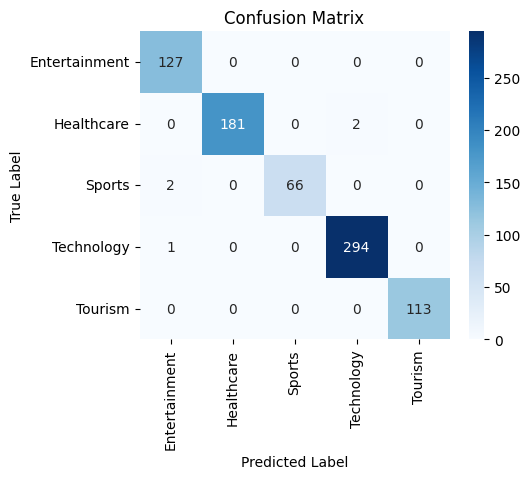

----------


In [61]:
# evaluating model
y_true = []
y_pred = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()

        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)

        y_true.extend(y_test_batch.cpu().numpy())
        y_pred.extend(predicted_test.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print('----------')
print('ANN with FastText embedding')
EvalMetricsMultiClass(y_true, y_pred,5)
print('----------')

# Model 3 : GRU

### (i) Word2Vec Embedding

In [62]:
from torch.utils.data import Dataset

class EmbeddingDataset2(Dataset):
    def __init__(self, textdata,labels,model,vec_size=100,max_len=100):
        self.xTrain = textdata
        self.vec_size=vec_size
        self.yTrain=labels
        self.model = model
        self.max_len=max_len

    def __getitem__(self, idx):
        text = self.xTrain.iloc[idx]
        # print()
        words = text.split()
        vectorized_words = [self.model.wv[word] for word in words if word in self.model.wv]
        if not vectorized_words:
          return np.zeros(self.vec_size)
        currlabel = self.yTrain[idx].clone().detach().float()

        return torch.tensor(vectorized_words, dtype=torch.float32), currlabel

    def __len__(self):
        return len(self.xTrain)


train_dataset = EmbeddingDataset2(train_texts, y_train_tensor,word2vec_model)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = EmbeddingDataset2(val_texts, y_val_tensor,word2vec_model)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataset = EmbeddingDataset2(test_texts, y_test_tensor,word2vec_model)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [63]:
class GRUModel(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=256, output_dim=5, num_layers=3, dropout=0.3):
        super(GRUModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.layer_norm(x)
        x = self.dropout(x)
        out = self.fc(x)
        return out

In [64]:

model = GRUModel(100,128,5,2)
model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to('cuda:0'), y_batch.to('cuda:0')
        output = model(X_batch)
        y_batch = y_batch.long()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_accuracy = correct_train / total_train

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to('cuda:0'), y_val_batch.to('cuda:0')
            output_val = model(X_val_batch)
            y_val_batch = y_val_batch.long()
            loss_val = criterion(output_val, y_val_batch)
            total_val_loss += loss_val.item()
            _, output = torch.max(output_val, 1)
            correct_val += (output == y_val_batch).sum().item()
            total_val += y_val_batch.size(0)

    val_accuracy = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()
        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)
        correct_test += (predicted_test == y_test_batch).sum().item()
        total_test += y_test_batch.size(0)

test_accuracy = correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.4f}")


Epoch [1/10], Train Acc: 0.8502, Val Acc: 0.8862
Epoch [2/10], Train Acc: 0.8777, Val Acc: 0.8659
Epoch [3/10], Train Acc: 0.8889, Val Acc: 0.9202
Epoch [4/10], Train Acc: 0.9002, Val Acc: 0.7547
Epoch [5/10], Train Acc: 0.9078, Val Acc: 0.9261
Epoch [6/10], Train Acc: 0.9292, Val Acc: 0.9185
Epoch [7/10], Train Acc: 0.9307, Val Acc: 0.9117
Epoch [8/10], Train Acc: 0.9379, Val Acc: 0.9185
Epoch [9/10], Train Acc: 0.9455, Val Acc: 0.9448
Epoch [10/10], Train Acc: 0.9491, Val Acc: 0.8421
Final Test Accuracy: 0.8601


----------
GRU with Word2Vec embedding
Accuracy: 0.8601, Precision: 0.8563, Recall: 0.8955, F1-Score: 0.8672

Classification Report:
Entertainment: Precision=0.90, Recall=0.97, F1-score=0.94
Healthcare: Precision=0.74, Recall=0.95, F1-score=0.83
Sports: Precision=0.68, Recall=0.85, F1-score=0.76
Technology: Precision=0.96, Recall=0.71, F1-score=0.81
Tourism: Precision=0.99, Recall=1.00, F1-score=1.00


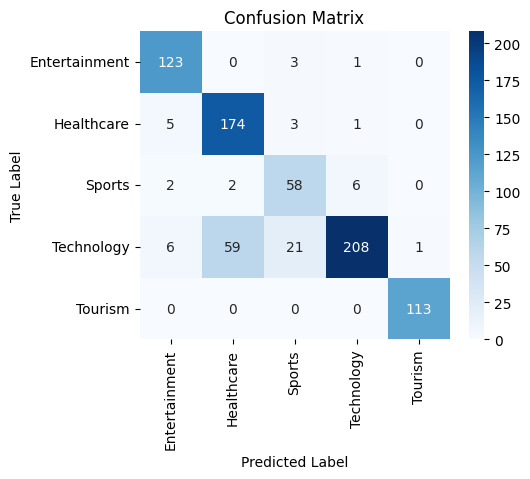

----------


In [65]:
y_true = []
y_pred = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()

        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)

        y_true.extend(y_test_batch.cpu().numpy())
        y_pred.extend(predicted_test.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print('----------')
print('GRU with Word2Vec embedding')
EvalMetricsMultiClass(y_true, y_pred,5)
print('----------')

### (ii) FastText Embedding

In [66]:
from torch.utils.data import Dataset

class EmbeddingDataset2(Dataset):
    def __init__(self, textdata,labels,model,vec_size=100,max_len=100):
        self.xTrain = textdata
        self.vec_size=vec_size
        self.yTrain=labels
        self.model = model
        self.max_len=max_len

    def __getitem__(self, idx):
        text = self.xTrain.iloc[idx]
        # print()
        words = text.split()
        vectorized_words = [self.model.wv[word] for word in words if word in self.model.wv]
        if not vectorized_words:
          return np.zeros(self.vec_size)
        currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)

        return torch.tensor(vectorized_words, dtype=torch.float32), currlabel

    def __len__(self):
        return len(self.xTrain)



train_dataset = EmbeddingDataset2(train_texts, y_train_tensor,fasttext_model)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = EmbeddingDataset2(val_texts, y_val_tensor,fasttext_model)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataset = EmbeddingDataset2(test_texts, y_test_tensor,fasttext_model)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [67]:

model = GRUModel(100,128,5,2)
model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to('cuda:0'), y_batch.to('cuda:0')
        output = model(X_batch)
        y_batch = y_batch.long()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_accuracy = correct_train / total_train

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to('cuda:0'), y_val_batch.to('cuda:0')
            output_val = model(X_val_batch)
            y_val_batch = y_val_batch.long()
            loss_val = criterion(output_val, y_val_batch)
            total_val_loss += loss_val.item()
            _, output = torch.max(output_val, 1)
            correct_val += (output == y_val_batch).sum().item()
            total_val += y_val_batch.size(0)

    val_accuracy = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()
        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)
        correct_test += (predicted_test == y_test_batch).sum().item()
        total_test += y_test_batch.size(0)

test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")


/tmp/ipykernel_1595496/1755682786.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)


Epoch [1/10], Train Acc: 0.8462, Val Acc: 0.8710
Epoch [2/10], Train Acc: 0.8675, Val Acc: 0.8565
Epoch [3/10], Train Acc: 0.8966, Val Acc: 0.8022
Epoch [4/10], Train Acc: 0.8961, Val Acc: 0.8973
Epoch [5/10], Train Acc: 0.9246, Val Acc: 0.9244
Epoch [6/10], Train Acc: 0.9175, Val Acc: 0.9015
Epoch [7/10], Train Acc: 0.8956, Val Acc: 0.9007
Epoch [8/10], Train Acc: 0.9358, Val Acc: 0.9066
Epoch [9/10], Train Acc: 0.9322, Val Acc: 0.9228
Epoch [10/10], Train Acc: 0.9195, Val Acc: 0.9228
Test Accuracy: 0.9211


/tmp/ipykernel_1595496/1755682786.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)


----------
GRU with FastText embedding
Accuracy: 0.9211, Precision: 0.9070, Recall: 0.9106, F1-Score: 0.9061

Classification Report:
Entertainment: Precision=0.97, Recall=0.92, F1-score=0.95
Healthcare: Precision=0.99, Recall=0.85, F1-score=0.91
Sports: Precision=0.67, Recall=0.82, F1-score=0.74
Technology: Precision=0.91, Recall=0.96, F1-score=0.93
Tourism: Precision=0.99, Recall=1.00, F1-score=1.00


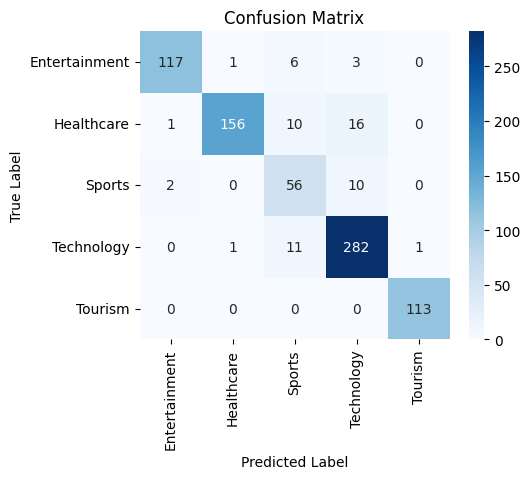

----------


In [68]:
y_true = []
y_pred = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()

        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)

        y_true.extend(y_test_batch.cpu().numpy())
        y_pred.extend(predicted_test.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print('----------')
print('GRU with FastText embedding')
EvalMetricsMultiClass(y_true, y_pred,5)
print('----------')

# Model 4 : Bidirectional LSTM

### (i) Word2Vec Embedding

In [69]:
from torch.utils.data import Dataset

class EmbeddingDataset2(Dataset):
    def __init__(self, textdata,labels,model,vec_size=100,max_len=100):
        self.xTrain = textdata
        self.vec_size=vec_size
        self.yTrain=labels
        self.model = model
        self.max_len=max_len

    def __getitem__(self, idx):
        text = self.xTrain.iloc[idx]
        # print()
        words = text.split()
        vectorized_words = [self.model.wv[word] for word in words if word in self.model.wv]
        if not vectorized_words:
          return np.zeros(self.vec_size)
        currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)

        return torch.tensor(vectorized_words, dtype=torch.float32), currlabel

    def __len__(self):
        return len(self.xTrain)



train_dataset = EmbeddingDataset2(train_texts, y_train_tensor,word2vec_model)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = EmbeddingDataset2(val_texts, y_val_tensor,word2vec_model)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataset = EmbeddingDataset2(test_texts, y_test_tensor,word2vec_model)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [70]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=256, output_dim=5, num_layers=3, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.layer_norm(x)
        x = self.dropout(x)
        out = self.fc(x)
        return out

In [71]:

model = LSTMModel(100,128,5,2)
model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to('cuda:0'), y_batch.to('cuda:0')
        output = model(X_batch)
        y_batch = y_batch.long()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_accuracy = correct_train / total_train

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to('cuda:0'), y_val_batch.to('cuda:0')
            output_val = model(X_val_batch)
            y_val_batch = y_val_batch.long()
            loss_val = criterion(output_val, y_val_batch)
            total_val_loss += loss_val.item()
            _, output = torch.max(output_val, 1)
            correct_val += (output == y_val_batch).sum().item()
            total_val += y_val_batch.size(0)

    val_accuracy = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()
        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)
        correct_test += (predicted_test == y_test_batch).sum().item()
        total_test += y_test_batch.size(0)

test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

/tmp/ipykernel_1595496/976813347.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)


Epoch [1/10], Train Acc: 0.9037, Val Acc: 0.8829
Epoch [2/10], Train Acc: 0.9592, Val Acc: 0.9745
Epoch [3/10], Train Acc: 0.9873, Val Acc: 0.9728
Epoch [4/10], Train Acc: 0.9715, Val Acc: 0.9830
Epoch [5/10], Train Acc: 0.9878, Val Acc: 0.9711
Epoch [6/10], Train Acc: 0.9842, Val Acc: 0.9898
Epoch [7/10], Train Acc: 0.9929, Val Acc: 0.9813
Epoch [8/10], Train Acc: 0.9868, Val Acc: 0.9932
Epoch [9/10], Train Acc: 0.9944, Val Acc: 0.9219
Epoch [10/10], Train Acc: 0.9888, Val Acc: 0.9788
Test Accuracy: 0.9784


/tmp/ipykernel_1595496/976813347.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)


----------
BiLSTM with Word2Vec embedding
Accuracy: 0.9784, Precision: 0.9807, Recall: 0.9783, F1-Score: 0.9790

Classification Report:
Entertainment: Precision=0.93, Recall=1.00, F1-score=0.96
Healthcare: Precision=1.00, Recall=0.94, F1-score=0.97
Sports: Precision=1.00, Recall=0.97, F1-score=0.99
Technology: Precision=0.98, Recall=0.99, F1-score=0.98
Tourism: Precision=1.00, Recall=0.99, F1-score=1.00


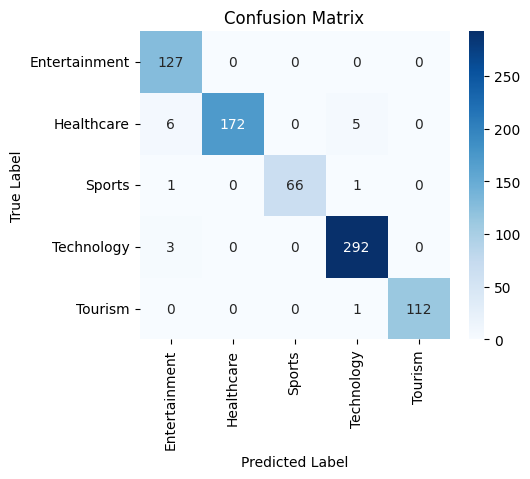

----------


In [72]:
y_true = []
y_pred = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()

        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)

        y_true.extend(y_test_batch.cpu().numpy())
        y_pred.extend(predicted_test.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print('----------')
print('BiLSTM with Word2Vec embedding')
EvalMetricsMultiClass(y_true, y_pred,5)
print('----------')

### (ii) FastText Embeddings

In [73]:
from torch.utils.data import Dataset

class EmbeddingDataset2(Dataset):
    def __init__(self, textdata,labels,model,vec_size=100,max_len=100):
        self.xTrain = textdata
        self.vec_size=vec_size
        self.yTrain=labels
        self.model = model
        self.max_len=max_len

    def __getitem__(self, idx):
        text = self.xTrain.iloc[idx]
        # print()
        words = text.split()
        vectorized_words = [self.model.wv[word] for word in words if word in self.model.wv]
        if not vectorized_words:
          return np.zeros(self.vec_size)
        currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)

        return torch.tensor(vectorized_words, dtype=torch.float32), currlabel

    def __len__(self):
        return len(self.xTrain)



train_dataset = EmbeddingDataset2(train_texts, y_train_tensor,fasttext_model)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = EmbeddingDataset2(val_texts, y_val_tensor,fasttext_model)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataset = EmbeddingDataset2(test_texts, y_test_tensor,fasttext_model)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [74]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=256, output_dim=5, num_layers=3, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.layer_norm(x)
        x = self.dropout(x)
        out = self.fc(x)
        return out

In [75]:

model = LSTMModel(100,128,5,2)
model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to('cuda:0'), y_batch.to('cuda:0')
        output = model(X_batch)
        y_batch = y_batch.long()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_accuracy = correct_train / total_train

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to('cuda:0'), y_val_batch.to('cuda:0')
            output_val = model(X_val_batch)
            y_val_batch = y_val_batch.long()
            loss_val = criterion(output_val, y_val_batch)
            total_val_loss += loss_val.item()
            _, output = torch.max(output_val, 1)
            correct_val += (output == y_val_batch).sum().item()
            total_val += y_val_batch.size(0)

    val_accuracy = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()
        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)
        correct_test += (predicted_test == y_test_batch).sum().item()
        total_test += y_test_batch.size(0)

test_accuracy = correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.4f}")


/tmp/ipykernel_1595496/1755682786.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)


Epoch [1/10], Train Acc: 0.9027, Val Acc: 0.9635
Epoch [2/10], Train Acc: 0.9506, Val Acc: 0.9584
Epoch [3/10], Train Acc: 0.9725, Val Acc: 0.9796
Epoch [4/10], Train Acc: 0.9837, Val Acc: 0.9762
Epoch [5/10], Train Acc: 0.9903, Val Acc: 0.9873
Epoch [6/10], Train Acc: 0.9883, Val Acc: 0.9737
Epoch [7/10], Train Acc: 0.9934, Val Acc: 0.9915
Epoch [8/10], Train Acc: 0.9969, Val Acc: 0.9915
Epoch [9/10], Train Acc: 0.9898, Val Acc: 0.9847
Epoch [10/10], Train Acc: 0.9918, Val Acc: 0.9839
Final Test Accuracy: 0.9873


/tmp/ipykernel_1595496/1755682786.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)


----------
BiLSTM with FastText embedding
Accuracy: 0.9873, Precision: 0.9817, Recall: 0.9907, F1-Score: 0.9860

Classification Report:
Entertainment: Precision=0.96, Recall=0.99, F1-score=0.98
Healthcare: Precision=0.99, Recall=0.98, F1-score=0.98
Sports: Precision=0.96, Recall=1.00, F1-score=0.98
Technology: Precision=1.00, Recall=0.98, F1-score=0.99
Tourism: Precision=1.00, Recall=1.00, F1-score=1.00


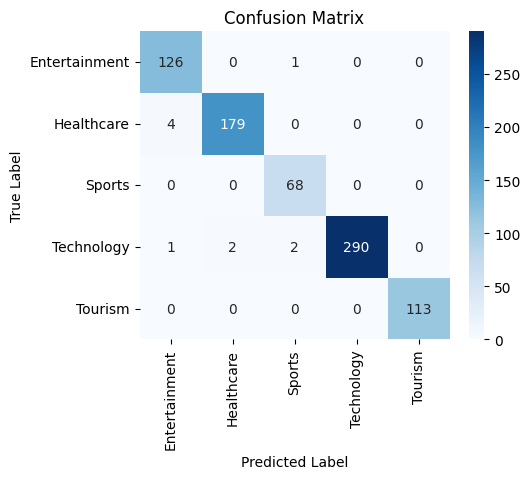

----------


In [76]:
y_true = []
y_pred = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()

        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)

        y_true.extend(y_test_batch.cpu().numpy())
        y_pred.extend(predicted_test.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print('----------')
print('BiLSTM with FastText embedding')
EvalMetricsMultiClass(y_true, y_pred,5)
print('----------')